In [1]:
import hdbscan
import pandas as pd
import geopandas as gpd
from shapely import wkb
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import numpy as np
from shapely.geometry import Polygon, MultiPolygon, Point, box
import seaborn as sns
from shapely.ops import unary_union
from geopandas.tools import sjoin
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
data = pd.read_csv('data.csv')

retail_data = data[data['voaCategory'] == 'RETAIL'].copy()

def hex_to_coordinates(voaPostcodeCentroid):
    point = wkb.loads(voaPostcodeCentroid, hex=True)
    return point.x, point.y

retail_data[['longitude', 'latitude']] = retail_data['voaPostcodeCentroid'].apply(lambda x: pd.Series(hex_to_coordinates(x)))
retail_data['geometry'] = retail_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf_retail = gpd.GeoDataFrame(retail_data, geometry='geometry', crs="EPSG:4326")

In [3]:
gdf_retail.shape

(361294, 12)

In [4]:
def clusterer(gdf_retail, cluster_size=15, cluster_distance=0.150):
    earth_radius_km = 6371
    epsilon = cluster_distance / earth_radius_km
    coordinates = [list(p.coords)[0] for p in gdf_retail["geometry"]]
    X = np.radians(coordinates)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size, 
                                metric="haversine",
                                cluster_selection_epsilon=epsilon,
                                cluster_selection_method = "eom")
    return clusterer.fit(X)

hdb = clusterer(retail_data)

gdf_retail['cluster'] = hdb.labels_

cluster_points = gdf_retail[gdf_retail['cluster'] >= 0]

print(gdf_retail['cluster'].value_counts())
print(gdf_retail.head())

cluster
-1       68828
 4406     2611
 3220     2144
 410      2052
 2045     1847
         ...  
 4220       15
 444        15
 1588       15
 144        15
 1452       15
Name: count, Length: 4427, dtype: int64
    voaUARN laBillingReferenceCode  \
1  32787000             3.2802E+12   
2  61673102            3.10021E+12   
3  61688102            3.10022E+12   
4  61694102            3.10022E+12   
5  61745102            3.10043E+12   

                                voaPropertyAddress voaPropertyPostcode  \
1  SPENCER, LINTHORPE ROAD, MIDDLESBROUGH, TS1 1RH             TS1 1RH   
2       122, ABINGDON ROAD, MIDDLESBROUGH, TS1 3JX             TS1 3JX   
3       152, ABINGDON ROAD, MIDDLESBROUGH, TS1 3JX             TS1 3JX   
4       154, ABINGDON ROAD, MIDDLESBROUGH, TS1 3JY             TS1 3JY   
5        286A, ACKLAM ROAD, MIDDLESBROUGH, TS5 8AY             TS5 8AY   

                          voaPostcodeCentroid  voaSCATCode  \
1  0101000000d8463cd9cdccf3bf404d2d5beb494b40      

<Figure size 1200x800 with 0 Axes>

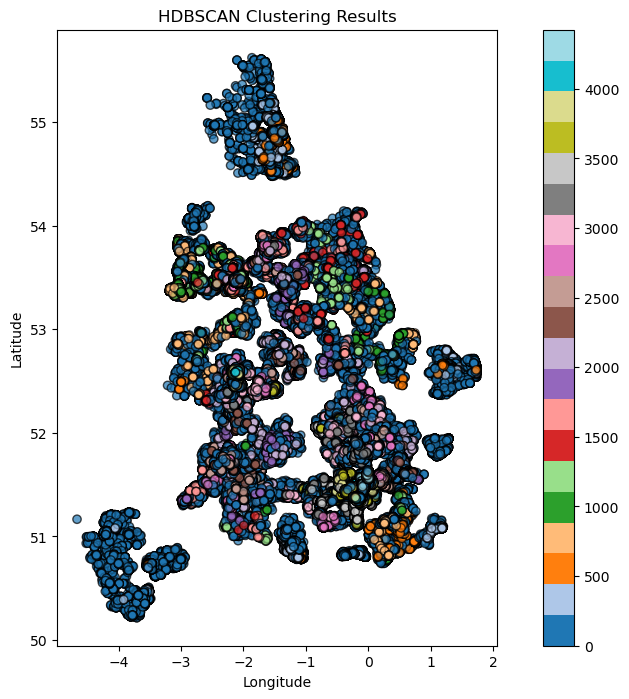

In [5]:
plt.figure(figsize=(12, 8))

palette = sns.color_palette('husl', n_colors=len(gdf_retail['cluster'].unique()))

gdf_retail.plot(column='cluster', cmap='tab20', edgecolor='k', alpha=0.7, legend=True, figsize=(12, 8))

plt.title('HDBSCAN Clustering Results')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

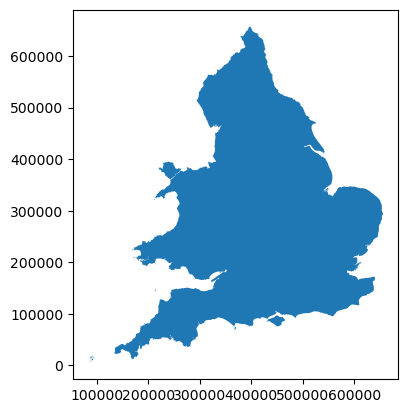

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\2316048953.py:5: DtypeWarning: Columns (15,20,21,23,30,31,32,37,40,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('NSPL_Online_Centroids_2400086033526942602.csv')


In [6]:
boundary = gpd.read_file('infuse_ew_2011/infuse_ew_2011.shp')
boundary.plot()
plt.show()

df = pd.read_csv('NSPL_Online_Centroids_2400086033526942602.csv')

geometry = [Point(xy) for xy in zip(df['LONG'], df['LAT'])]
crs = 'EPSG:4326' 

gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

gdf = gdf.to_crs(epsg=4326)

boundary = boundary.to_crs(gdf.crs)

In [7]:
points_within_boundary = gpd.sjoin(gdf, boundary, how='inner', predicate='within')

points = np.array([(geom.x, geom.y) for geom in points_within_boundary.geometry])

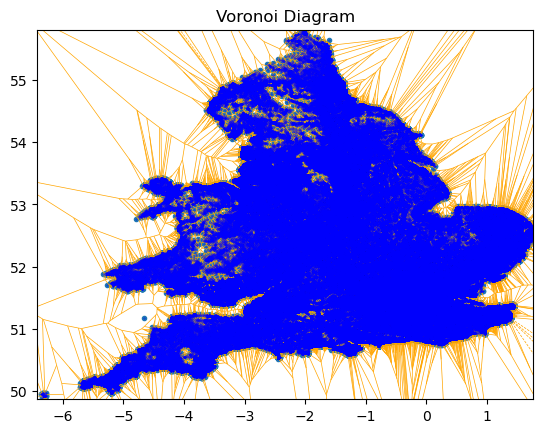

In [8]:
vor = Voronoi(points)

fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='orange', line_width=0.5, line_alpha=1)

ax.plot(points[:, 0], points[:, 1], 'o', markersize=0.25, color='blue')

minx, miny, maxx, maxy = boundary.total_bounds

ax.set_title('Voronoi Diagram')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

plt.show()

In [9]:
voronoi_polygons = []
for region in vor.regions:
    if not region or -1 in region:
        continue
    polygon = Polygon([vor.vertices[i] for i in region])
    voronoi_polygons.append(polygon)

voronoi_gdf = gpd.GeoDataFrame(geometry=voronoi_polygons, crs="EPSG:4326")

In [10]:
%%time
simplified_voronoi_gdf = voronoi_gdf.copy()
simplified_boundary_gdf = boundary.copy()
simplified_voronoi_gdf['geometry'] = simplified_voronoi_gdf['geometry'].simplify(tolerance=0.01)
simplified_boundary_gdf['geometry'] = simplified_boundary_gdf['geometry'].simplify(tolerance=0.01)

intersection_gdf = gpd.overlay(simplified_voronoi_gdf, simplified_boundary_gdf, how='intersection')

CPU times: total: 4min 41s
Wall time: 4min 50s


<function matplotlib.pyplot.show(close=None, block=None)>

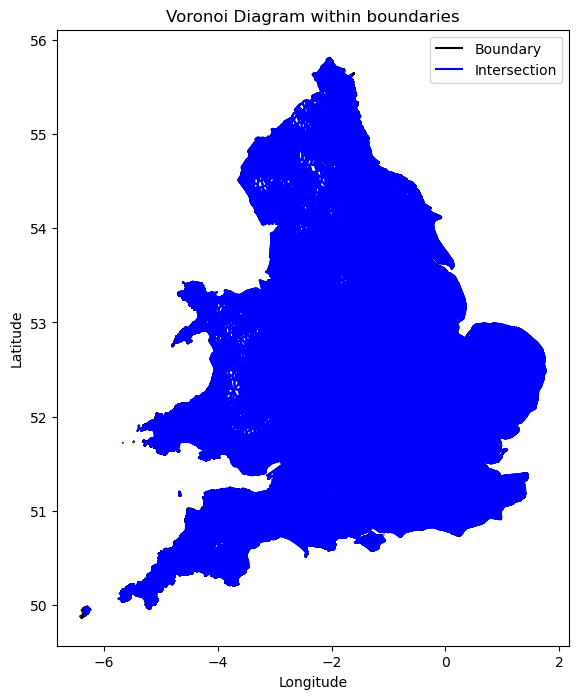

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
boundary.boundary.plot(ax=ax, color='black', label='Boundary')
intersection_gdf.boundary.plot(ax=ax, color='blue', label='Intersection')
plt.title('Voronoi Diagram within boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show

In [12]:
cluster_points_geom = cluster_points.geometry

In [13]:
%%time


sindex = cluster_points.sindex

def polygon_contains_any_point(polygon):
    possible_matches_index = list(sindex.intersection(polygon.bounds))
    possible_matches = cluster_points.iloc[possible_matches_index]
    for point in possible_matches.geometry:
        if polygon.contains(point):
            return possible_matches[possible_matches.geometry == point]['cluster'].values[0]
    return None

print("Filtering Voronoi polygons...")
filtered_voronoi_polygons = []

with ThreadPoolExecutor() as executor:
    futures = {executor.submit(polygon_contains_any_point, polygon): polygon for polygon in voronoi_polygons}
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="Filtering Voronoi polygons"):
        polygon = futures[future]
        cluster_value = future.result()
        if cluster_value is not None:
            filtered_voronoi_polygons.append((polygon, cluster_value))

Filtering Voronoi polygons...


Filtering Voronoi polygons: 100%|██████████| 1807428/1807428 [00:50<00:00, 35651.26it/s] 

CPU times: total: 2min 53s
Wall time: 20min 55s


In [14]:
filtered_voronoi_gdf = gpd.GeoDataFrame(
    filtered_voronoi_polygons,
    columns=['geometry', 'cluster']
)

print(filtered_voronoi_gdf)

                                                geometry  cluster
0      POLYGON ((-1.62667 54.74942, -1.62539 54.74901...      500
1      POLYGON ((-0.46684 51.43511, -0.46693 51.43513...     3764
2      POLYGON ((-0.01618 51.59498, -0.01543 51.59454...     4225
3      POLYGON ((-1.63086 54.75412, -1.62991 54.75429...      500
4      POLYGON ((-2.17099 53.02177, -2.17152 53.02226...     1930
...                                                  ...      ...
54604  POLYGON ((-0.13409 51.51793, -0.13408 51.51795...     4406
54605  POLYGON ((-1.46602 53.2993, -1.46597 53.29912,...     1896
54606  POLYGON ((-0.13409 51.5179, -0.13406 51.51786,...     4406
54607  POLYGON ((-0.1342 51.51785, -0.13425 51.51773,...     4406
54608  POLYGON ((-1.46564 53.29997, -1.46553 53.30017...     1896

[54609 rows x 2 columns]


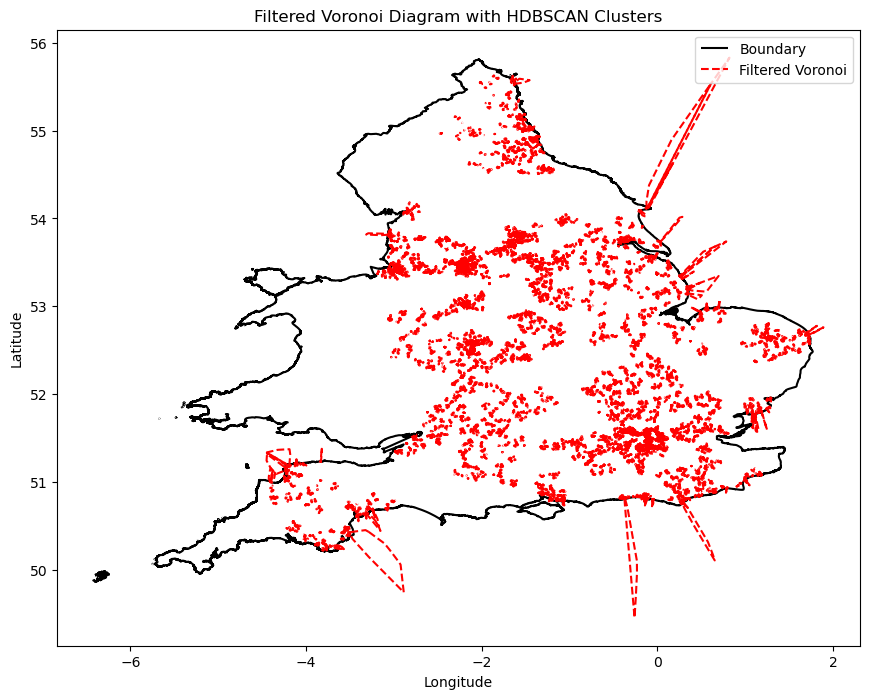

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
boundary.boundary.plot(ax=ax, color='black', label='Boundary')
filtered_voronoi_gdf.boundary.plot(ax=ax, color='red', linestyle='--', label='Filtered Voronoi')
plt.title('Filtered Voronoi Diagram with HDBSCAN Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [16]:
data[['longitude', 'latitude']] = data['voaPostcodeCentroid'].apply(lambda x: pd.Series(hex_to_coordinates(x)))
data['geometry'] = data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf1 = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:4326")

In [17]:
gdf1 = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

gdf1.set_crs("EPSG:4326", inplace=True)
filtered_voronoi_gdf.set_crs("EPSG:4326", inplace=True)

joined_gdf = gpd.sjoin(gdf1, filtered_voronoi_gdf, how='inner', predicate='within')

filtered_gdf = joined_gdf.drop(columns=['index_right'])

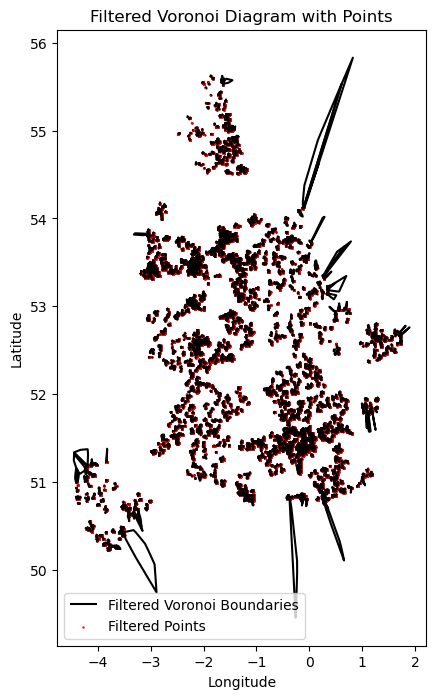

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
filtered_voronoi_gdf.boundary.plot(ax=ax, color='black', label='Filtered Voronoi Boundaries')
filtered_gdf.plot(ax=ax, color='red', markersize=0.5, label='Filtered Points')
plt.title('Filtered Voronoi Diagram with Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [19]:
filtered_gdf.to_csv('filtered_points.csv', index=False)

In [20]:
gdf_retail_filtered = gdf_retail[gdf_retail['cluster'] != -1]
data_filtered = data[data.voaPropertyPostcode.isin(gdf_retail_filtered['voaPropertyPostcode'])]
data_filtered.to_csv('data_checking.csv', index=False)

In [21]:
voaUARN1 = [int(voaUARN) for voaUARN in filtered_gdf['voaUARN']]
voaUARN2 = [int(voaUARN) for voaUARN in data_filtered['voaUARN']]


set1 = set(voaUARN1)
set2 = set(voaUARN2)

diff1 = set1 - set2 
diff2 = set2 - set1 

diff1_count = len(diff1)
diff2_count = len(diff2)

rows_filtered_gdf = filtered_gdf.shape[0]
rows_data_filtered = data_filtered.shape[0]

print("Number of rows in filtered_gdf:", rows_filtered_gdf)
print("Number of rows in data_filtered:", rows_data_filtered)
print("Number of UARNs in filtered_gdf but not in data_filtered:", diff1_count)
print("Number of UARNs in data_filtered but not in filtered_gdf:", diff2_count)

Number of rows in filtered_gdf: 502795
Number of rows in data_filtered: 500840
Number of UARNs in filtered_gdf but not in data_filtered: 1982
Number of UARNs in data_filtered but not in filtered_gdf: 27


In [22]:
filtered_voronoi_gdf

,geometry,cluster
0,"POLYGON ((-1.62667 54.74942, -1.62539 54.74901...",500
1,"POLYGON ((-0.46684 51.43511, -0.46693 51.43513...",3764
2,"POLYGON ((-0.01618 51.59498, -0.01543 51.59454...",4225
3,"POLYGON ((-1.63086 54.75412, -1.62991 54.75429...",500
4,"POLYGON ((-2.17099 53.02177, -2.17152 53.02226...",1930
...,...,...
54604,"POLYGON ((-0.13409 51.51793, -0.13408 51.51795...",4406
54605,"POLYGON ((-1.46602 53.2993, -1.46597 53.29912,...",1896
54606,"POLYGON ((-0.13409 51.5179, -0.13406 51.51786,...",4406
54607,"POLYGON ((-0.1342 51.51785, -0.13425 51.51773,...",4406


In [23]:
def cluster_dominance(file_path, filtered_gdf, filtered_voronoi_gdf):
    
    df = pd.read_csv(file_path)
        
    cdf = pd.merge(df, filtered_gdf[['voaUARN', 'geometry']], on='voaUARN', how='left')
    
    cdf_gdf = gpd.GeoDataFrame(cdf, geometry='geometry', crs='EPSG:4326')
    filtered_voronoi_gdf = filtered_voronoi_gdf.set_crs('EPSG:4326')
    
    joined_gdf = gpd.sjoin(cdf_gdf, filtered_voronoi_gdf, how='left', predicate='within')
    cdf['cluster'] = joined_gdf['cluster']
    cdf = cdf.dropna(subset=['laRatesPaid', 'voaRateableValue','laOccupationState'])
    
    
    return cdf

In [24]:
cdf2019 = cluster_dominance('data/2019.csv', filtered_gdf, filtered_voronoi_gdf)
cdf2020 = cluster_dominance('data/2020.csv', filtered_gdf, filtered_voronoi_gdf)
cdf2021 = cluster_dominance('data/2021.csv', filtered_gdf, filtered_voronoi_gdf)
cdf2022 = cluster_dominance('data/2022.csv', filtered_gdf, filtered_voronoi_gdf)
cdf2023 = cluster_dominance('data/2023.csv', filtered_gdf, filtered_voronoi_gdf)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\544547418.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [25]:
import matplotlib.pyplot as plt

def plot_retail_dependence(cdf, year):
    # Filter the dataframe
    cdf = cdf[cdf['laRatesPaid'] < 0.65 * cdf['voaRateableValue']]
    cdf['Rates Paid/Valuation'] = cdf['laRatesPaid'] / cdf['voaRateableValue']
    
    # Group by cluster and voaCategory, then sum the floor areas
    floor_area_sums = cdf.groupby(['cluster', 'voaCategory'])['voaFloorArea'].sum().unstack(fill_value=0)
    
    # Calculate retail ratio as the proportion of floor area in 'RETAIL' category for each cluster
    floor_area_sums['retail_ratio'] = floor_area_sums['RETAIL'] / floor_area_sums.sum(axis=1)
    
    # Merge the retail_ratio back into the original dataframe
    cdf = cdf.merge(floor_area_sums[['retail_ratio']], left_on='cluster', right_index=True)

    # Plot 1: Retail Dependence vs. Rates Paid/Valuation
    plt.figure(figsize=(10, 6))
    plt.scatter(cdf['retail_ratio'], cdf['Rates Paid/Valuation'], color='blue', s=15, marker='o')
    plt.axvline(x=0.4, color='red', linestyle='--', linewidth=2)  # Add vertical line at 0.4
    plt.axvline(x=0.6, color='red', linestyle='--', linewidth=2)  # Add vertical line at 0.6
    plt.xlabel('Retail Dependence')
    plt.ylabel('Rates Paid/Valuation')
    plt.title(f'Retail Dependence vs. Rates Paid/Valuation for {year}')
    plt.ylim(0, 0.65)
    plt.grid(True)
    plt.show()
    
    # Calculate percentage of False in OccupationState for each cluster
    vacancy_percentage = cdf.groupby('cluster')['laOccupationState'].apply(lambda x: (x == False).mean())
    
    # Merge occupation_state_false_percentage back to the main dataframe on the cluster
    cdf = cdf.merge(vacancy_percentage.rename('vacancy_percentage'), left_on='cluster', right_index=True)
    
    # Plot 2: Retail Dependence vs. False Percentage in OccupationState
    plt.figure(figsize=(10, 6))
    plt.scatter(cdf['retail_ratio'], cdf['vacancy_percentage'], color='blue', s=15, marker='o')
    plt.axvline(x=0.4, color='red', linestyle='--', linewidth=2)  # Add vertical line at 0.4
    plt.axvline(x=0.6, color='red', linestyle='--', linewidth=2)  # Add vertical line at 0.6
    plt.xlabel('Retail Dependence')
    plt.ylabel('Vacancy Percentage')
    plt.title(f'Retail Dependence vs. Vacancy Percentage in OccupationState for {year}')
    plt.grid(True)
    plt.show()

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\917945939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Rates Paid/Valuation'] = cdf['laRatesPaid'] / cdf['voaRateableValue']


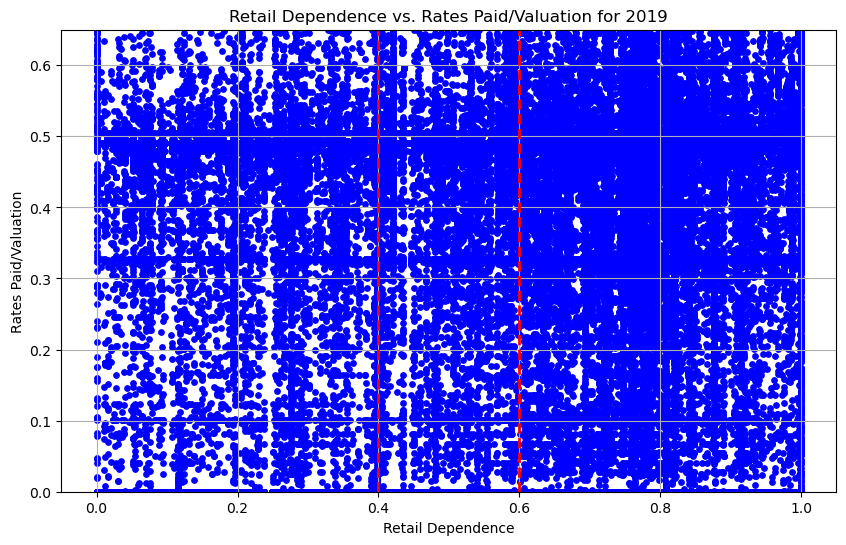

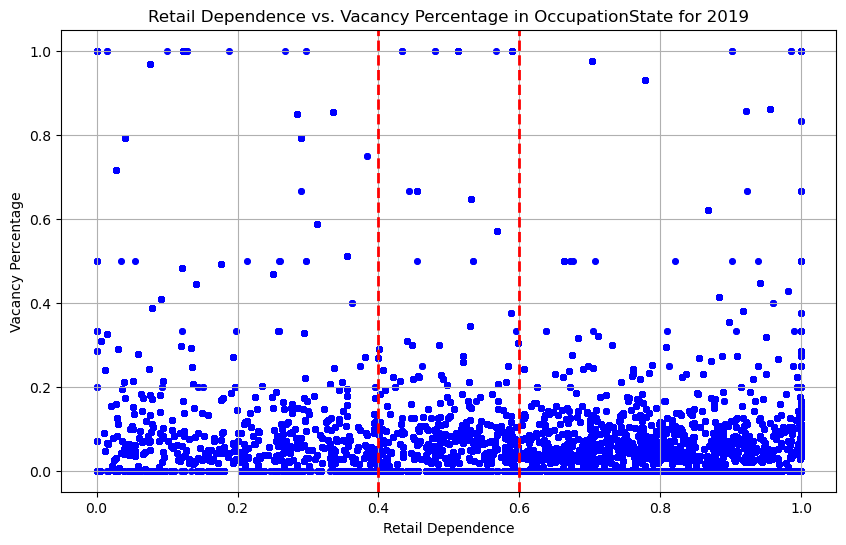

In [26]:
plot_retail_dependence(cdf2019, 2019)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\917945939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Rates Paid/Valuation'] = cdf['laRatesPaid'] / cdf['voaRateableValue']


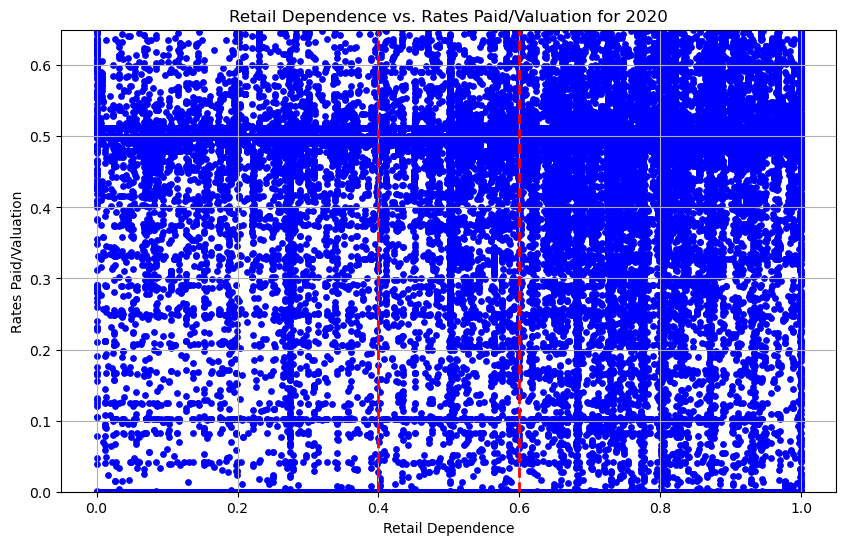

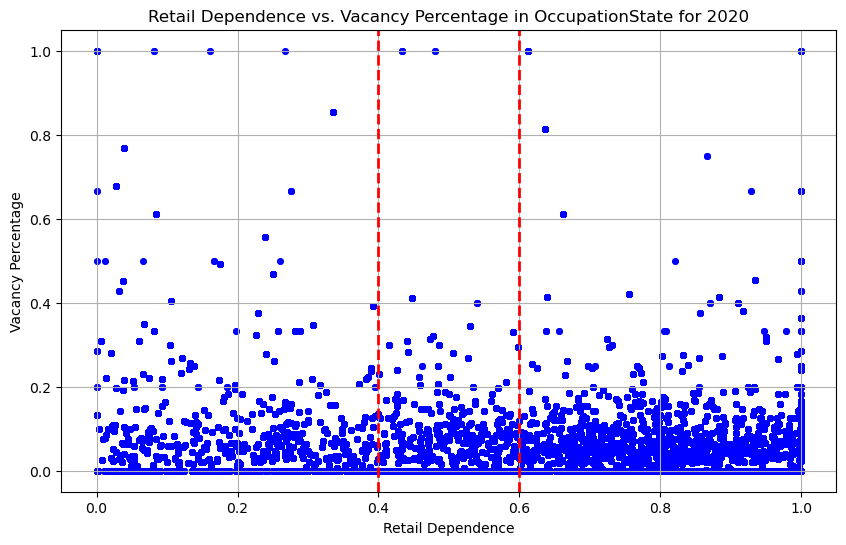

In [27]:
plot_retail_dependence(cdf2020, 2020)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\917945939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Rates Paid/Valuation'] = cdf['laRatesPaid'] / cdf['voaRateableValue']


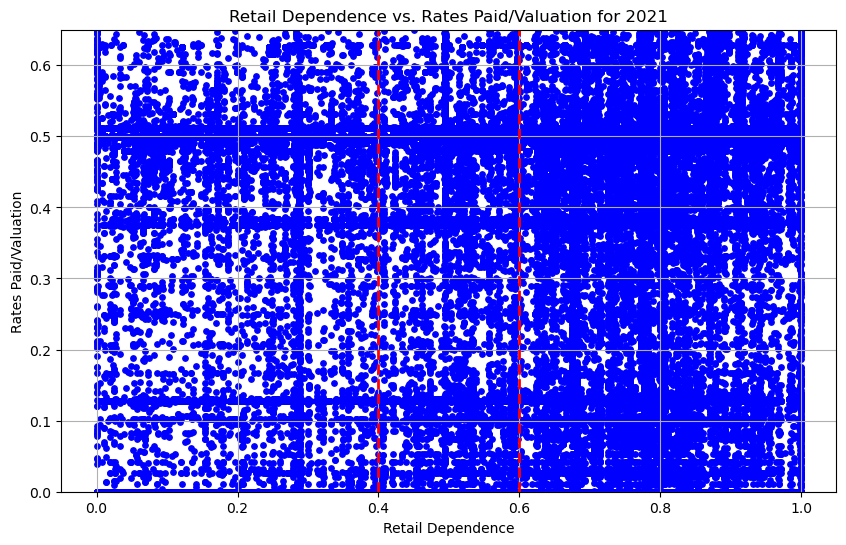

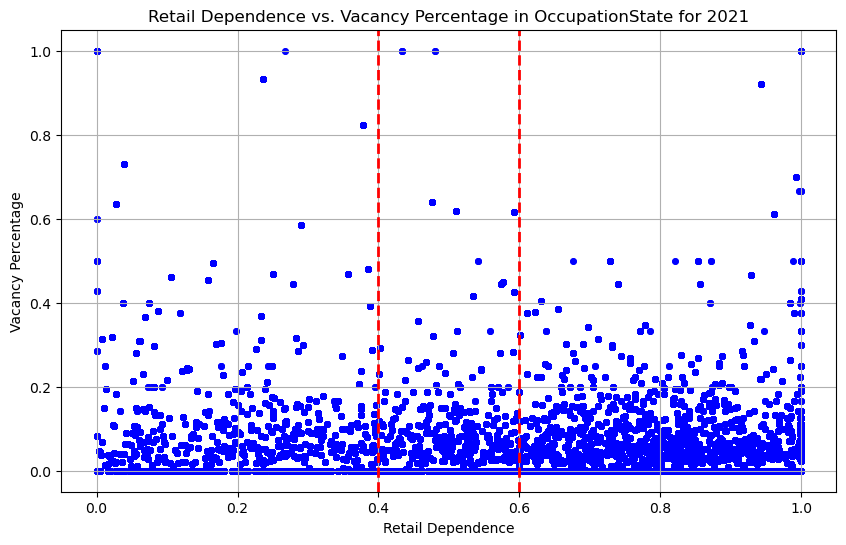

In [28]:
plot_retail_dependence(cdf2021, 2021)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\917945939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Rates Paid/Valuation'] = cdf['laRatesPaid'] / cdf['voaRateableValue']


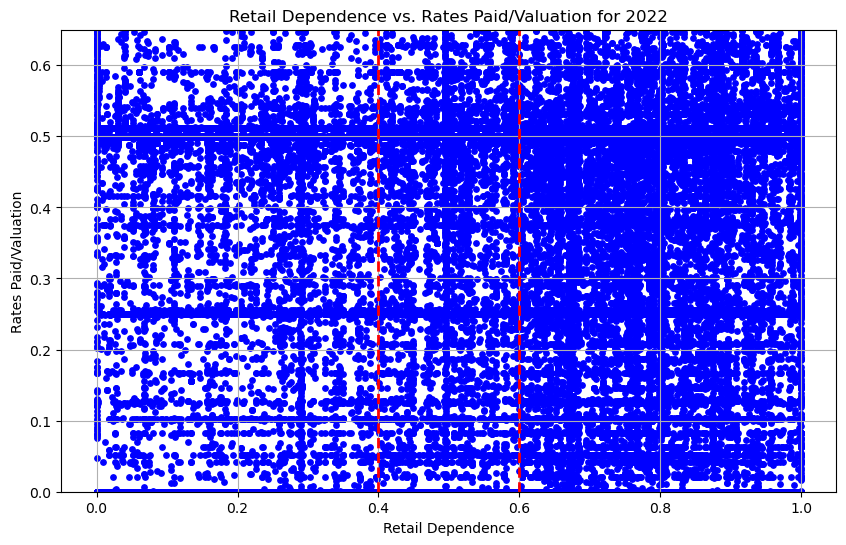

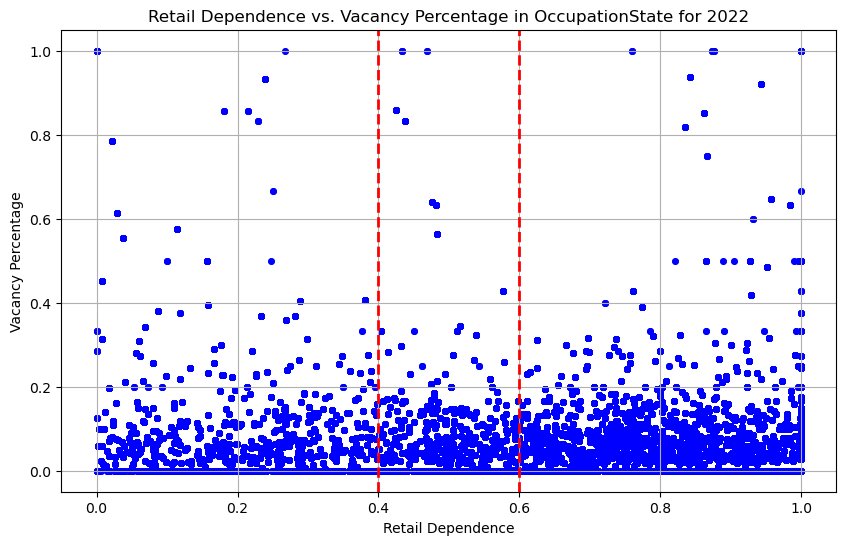

In [29]:
plot_retail_dependence(cdf2022, 2022)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\917945939.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['Rates Paid/Valuation'] = cdf['laRatesPaid'] / cdf['voaRateableValue']


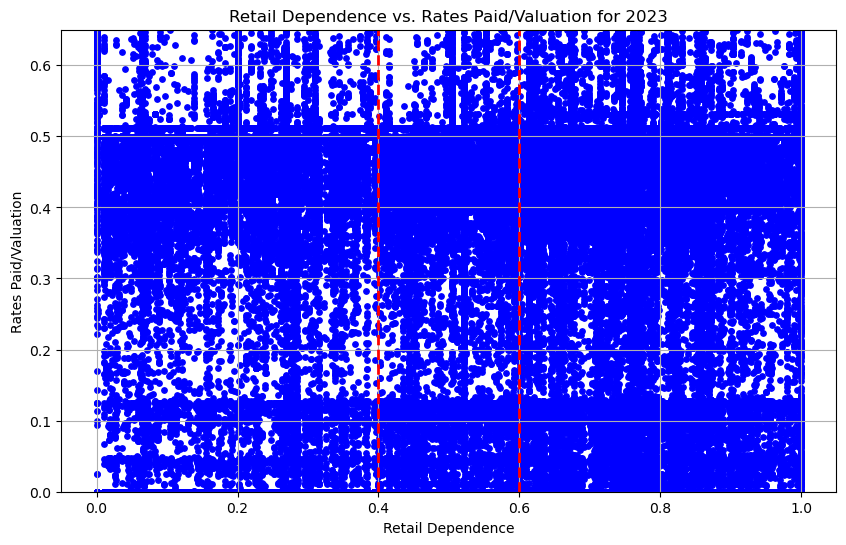

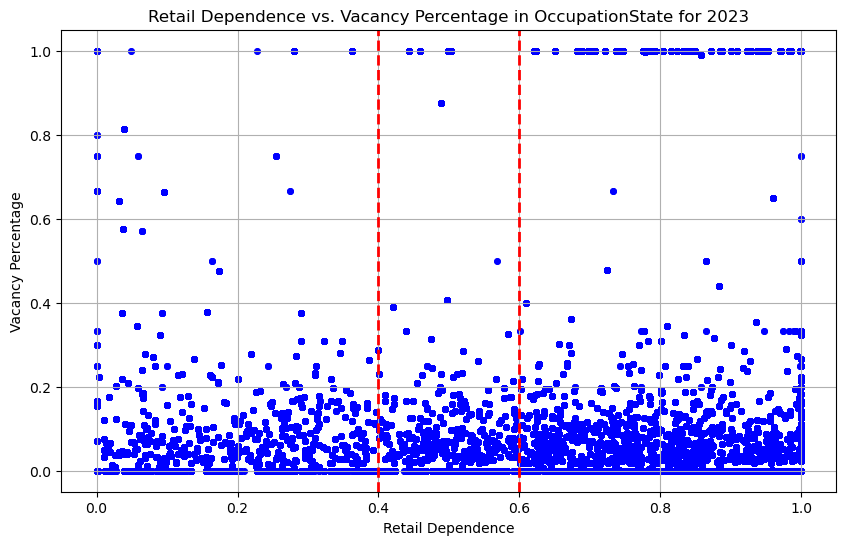

In [30]:
plot_retail_dependence(cdf2023, 2023)

In [31]:
def valuation_rates_analysis(file_path, filtered_gdf, filtered_voronoi_gdf):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Drop rows with NaNs in 'voaFloorArea' and 'voaRateableValue'
    rdf = df.dropna(subset=['voaFloorArea', 'voaRateableValue'])
    print("Shape after dropping NaNs in voaFloorArea and voaRateableValue:", rdf.shape)
    
    # Take absolute values of 'voaRateableValue' and 'laRatesPaid'
    rdf['voaRateableValue'] = rdf['voaRateableValue'].abs()
    rdf['laRatesPaid'] = rdf['laRatesPaid'].abs()
    
    # Merge with filtered_gdf to add geometry
    ndf = pd.merge(rdf, filtered_gdf[['voaUARN', 'geometry']], on='voaUARN', how='left')
    
    # Convert to GeoDataFrame
    ndf_gdf = gpd.GeoDataFrame(ndf, geometry='geometry', crs='EPSG:4326')
    
    # Ensure filtered_voronoi_gdf has the correct CRS
    filtered_voronoi_gdf = filtered_voronoi_gdf.set_crs('EPSG:4326')
    
    # Perform spatial join to determine clusters
    joined_gdf = gpd.sjoin(ndf_gdf, filtered_voronoi_gdf, how='left', predicate='within')
    ndf['cluster'] = joined_gdf['cluster']
    
    # Filter based on the condition for laRatesPaid and voaRateableValue
    ndf = ndf[ndf['laRatesPaid'] < 0.65 * ndf['voaRateableValue']]
    print('Number of properties with a reasonable amount of tax paid:', ndf.shape)
    
    # Group by cluster and voaCategory, then sum the floor areas
    floor_area_sums = ndf.groupby(['cluster', 'voaCategory'])['voaFloorArea'].sum().unstack(fill_value=0)
    
    # Calculate retail ratio as the proportion of floor area in 'RETAIL' category for each cluster
    floor_area_sums['retail_ratio'] = floor_area_sums['RETAIL'] / floor_area_sums.sum(axis=1)
    
    # Merge the retail_ratio back into the ndf dataframe using 'cluster'
    ndf = ndf.merge(floor_area_sums[['retail_ratio']], on='cluster', how='left')
    
    # Group by cluster and calculate aggregate values, including 'retail_ratio'
    grouped = ndf.groupby('cluster').agg({
        'voaFloorArea': 'sum',
        'voaRateableValue': 'sum',
        'laRatesPaid': 'sum',
        'retail_ratio': 'mean'  # Ensure retail_ratio is included in the aggregation
    }).reset_index()
    
    # Calculate value per square metre and rate per square metre
    grouped['value_per_square_metre'] = grouped['voaRateableValue'] / grouped['voaFloorArea']
    grouped['rate_per_square_metre'] = grouped['laRatesPaid'] / grouped['voaFloorArea']
    
    return grouped

In [32]:
grouped2019 = valuation_rates_analysis('data/2019.csv', filtered_gdf, filtered_voronoi_gdf)

Shape after dropping NaNs in voaFloorArea and voaRateableValue: (432764, 28)


C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['voaRateableValue'] = rdf['voaRateableValue'].abs()
C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['laRatesPaid'] = rdf['laRatesPaid'].abs()


Number of properties with a reasonable amount of tax paid: (139783, 30)


In [33]:
grouped2020 = valuation_rates_analysis('data/2020.csv', filtered_gdf, filtered_voronoi_gdf)

Shape after dropping NaNs in voaFloorArea and voaRateableValue: (443475, 28)


C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['voaRateableValue'] = rdf['voaRateableValue'].abs()
C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['laRatesPaid'] = rdf['laRatesPaid'].abs()


Number of properties with a reasonable amount of tax paid: (163045, 30)


In [34]:
grouped2021 = valuation_rates_analysis('data/2021.csv', filtered_gdf, filtered_voronoi_gdf)

Shape after dropping NaNs in voaFloorArea and voaRateableValue: (453762, 28)


C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['voaRateableValue'] = rdf['voaRateableValue'].abs()
C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['laRatesPaid'] = rdf['laRatesPaid'].abs()


Number of properties with a reasonable amount of tax paid: (165309, 30)


In [35]:
grouped2022 = valuation_rates_analysis('data/2022.csv', filtered_gdf, filtered_voronoi_gdf)

Shape after dropping NaNs in voaFloorArea and voaRateableValue: (460808, 28)


C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['voaRateableValue'] = rdf['voaRateableValue'].abs()
C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['laRatesPaid'] = rdf['laRatesPaid'].abs()


Number of properties with a reasonable amount of tax paid: (176096, 30)


In [36]:
grouped2023 = valuation_rates_analysis('data/2023.csv', filtered_gdf, filtered_voronoi_gdf)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Shape after dropping NaNs in voaFloorArea and voaRateableValue: (457690, 28)


C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['voaRateableValue'] = rdf['voaRateableValue'].abs()
C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3385885017.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['laRatesPaid'] = rdf['laRatesPaid'].abs()


Number of properties with a reasonable amount of tax paid: (161318, 30)


In [37]:
def combine_multiple_columns(dfs, *column_names):
    """
    Combine specified columns from a list of DataFrames into a single DataFrame.
    
    :param dfs: List of DataFrames.
    :param column_names: Column names to combine.
    :return: DataFrame with combined columns.
    """
    combined_df = pd.DataFrame()
    
    for column_name in column_names:
        columns_to_combine = [df[column_name] for df in dfs if column_name in df.columns]
        
        # Check if there are columns to combine for the current column_name
        if not columns_to_combine:
            raise KeyError(f"Column '{column_name}' is missing in some DataFrames.")
        
        temp_df = pd.concat(columns_to_combine, axis=1)
        temp_df.columns = [f'df{i+1}_{column_name}' for i in range(len(columns_to_combine))]
        combined_df = pd.concat([combined_df, temp_df], axis=1)
    
    return combined_df

In [38]:
rgroups = [grouped2019,grouped2020,grouped2021,grouped2022,grouped2023]

In [39]:
ratable_value = combine_multiple_columns(rgroups, 'value_per_square_metre','retail_ratio','cluster','voaFloorArea')
RatesPaid = combine_multiple_columns(rgroups,'rate_per_square_metre','retail_ratio','cluster','voaFloorArea')

In [40]:
valuation_year = ['2019', '2020', '2021', '2022', '2023']
ratable_value.columns = valuation_year + ratable_value.columns[5:].tolist()
ratable_value

,2019,2020,2021,2022,2023,df1_retail_ratio,df2_retail_ratio,df3_retail_ratio,df4_retail_ratio,df5_retail_ratio,df1_cluster,df2_cluster,df3_cluster,df4_cluster,df5_cluster,df1_voaFloorArea,df2_voaFloorArea,df3_voaFloorArea,df4_voaFloorArea,df5_voaFloorArea
0,132.105685,38.309115,63.063063,1000.000000,127.800474,1.000000,1.000000,0.974260,0.000000,0.826015,0.0,1.0,1.0,1,3.0,1748.60,75.70,77.70,2.00,1921.55
1,54.882890,136.010150,136.010150,131.171935,102.124152,0.150258,0.839116,0.839116,0.782060,0.998488,1.0,3.0,3.0,3,4.0,503.80,1891.55,1891.55,2029.55,1322.41
2,275.000000,108.516245,109.271298,110.026351,78.704708,0.000000,0.996980,0.996980,0.996980,0.752658,2.0,4.0,4.0,4,5.0,1.00,1324.41,1324.41,1324.41,921.80
3,135.164283,56.682147,96.456693,58.730942,92.524803,0.839116,0.968212,0.634216,0.625064,0.636705,3.0,5.0,5.0,5,7.0,1891.55,1733.35,139.70,3322.78,2281.01
4,110.738082,68.294068,126.929373,123.113287,100.307898,0.996565,0.611499,0.763913,0.900207,0.338681,4.0,7.0,6.0,6,8.0,1164.64,2042.93,3243.93,1611.93,7154.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,NaN,NaN,NaN,213.216958,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,4408,NaN,NaN,NaN,NaN,401.00,NaN
2976,NaN,NaN,NaN,288.484416,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,4412,NaN,NaN,NaN,NaN,168.12,NaN
2977,NaN,NaN,NaN,612.753407,NaN,NaN,NaN,NaN,0.996610,NaN,NaN,NaN,NaN,4421,NaN,NaN,NaN,NaN,294.98,NaN
2978,NaN,NaN,NaN,4000.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,4422,NaN,NaN,NaN,NaN,2.00,NaN


In [41]:
rate_year = ['2019', '2020', '2021', '2022', '2023']
RatesPaid.columns = rate_year + ratable_value.columns[5:].tolist()
RatesPaid

,2019,2020,2021,2022,2023,df1_retail_ratio,df2_retail_ratio,df3_retail_ratio,df4_retail_ratio,df5_retail_ratio,df1_cluster,df2_cluster,df3_cluster,df4_cluster,df5_cluster,df1_voaFloorArea,df2_voaFloorArea,df3_voaFloorArea,df4_voaFloorArea,df5_voaFloorArea
0,0.000000,0.000000,0.000000,0.000000,64.473196,1.000000,1.000000,0.974260,0.000000,0.826015,0.0,1.0,1.0,1,3.0,1748.60,75.70,77.70,2.00,1921.55
1,0.000000,51.728672,58.391742,45.929418,52.190599,0.150258,0.839116,0.839116,0.782060,0.998488,1.0,3.0,3.0,3,4.0,503.80,1891.55,1891.55,2029.55,1322.41
2,0.000000,18.802357,27.981773,23.782145,34.444294,0.000000,0.996980,0.996980,0.996980,0.752658,2.0,4.0,4.0,4,5.0,1.00,1324.41,1324.41,1324.41,921.80
3,59.830441,3.879211,48.131926,9.597313,41.216829,0.839116,0.968212,0.634216,0.625064,0.636705,3.0,5.0,5.0,5,7.0,1891.55,1733.35,139.70,3322.78,2281.01
4,46.067085,24.284753,11.824669,10.029592,49.927635,0.996565,0.611499,0.763913,0.900207,0.338681,4.0,7.0,6.0,6,8.0,1164.64,2042.93,3243.93,1611.93,7154.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2975,NaN,NaN,NaN,102.244389,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,4408,NaN,NaN,NaN,NaN,401.00,NaN
2976,NaN,NaN,NaN,123.423745,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,4412,NaN,NaN,NaN,NaN,168.12,NaN
2977,NaN,NaN,NaN,267.136755,NaN,NaN,NaN,NaN,0.996610,NaN,NaN,NaN,NaN,4421,NaN,NaN,NaN,NaN,294.98,NaN
2978,NaN,NaN,NaN,380.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,4422,NaN,NaN,NaN,NaN,2.00,NaN


In [42]:
RatesPaid_subset = RatesPaid.iloc[:, :5]
ratable_value_subset = ratable_value.iloc[:, :5]

adv_rate_relief = RatesPaid_subset / ratable_value_subset
ratable_value_last_15 = ratable_value.iloc[:, -15:]

adv_rate_relief = pd.concat([adv_rate_relief, ratable_value_last_15], axis=1)
print(adv_rate_relief)

         2019      2020      2021      2022      2023  df1_retail_ratio  \
0     0.00000  0.000000  0.000000  0.000000  0.504483          1.000000   
1     0.00000  0.380329  0.429319  0.350147  0.511050          0.150258   
2     0.00000  0.173268  0.256076  0.216150  0.437640          0.000000   
3     0.44265  0.068438  0.499000  0.163412  0.445468          0.839116   
4     0.41600  0.355591  0.093159  0.081466  0.497744          0.996565   
...       ...       ...       ...       ...       ...               ...   
2975      NaN       NaN       NaN  0.479532       NaN               NaN   
2976      NaN       NaN       NaN  0.427835       NaN               NaN   
2977      NaN       NaN       NaN  0.435961       NaN               NaN   
2978      NaN       NaN       NaN  0.095000       NaN               NaN   
2979      NaN       NaN       NaN  0.391089       NaN               NaN   

      df2_retail_ratio  df3_retail_ratio  df4_retail_ratio  df5_retail_ratio  \
0             1.000

In [43]:
def plot_histograms(data1, data2, year, bins=1000, alpha=0.6):
    fig, ax = plt.subplots()

    x_range = (0, 500)
    y_range = (0, 60)
    
    color1 = 'tab:blue'
    ax.hist(data1, bins=bins, alpha=alpha, color=color1, range=x_range, label='Ratable Value')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency', color=color1)
    ax.tick_params(axis='y', labelcolor=color1)

    color2 = 'tab:red'
    ax.hist(data2, bins=bins, alpha=alpha, color=color2, range=x_range, label='Rates Paid')
    
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    
    ax.legend(loc='upper right')
    
    # Dynamically set the title based on the year
    title = f'Histogram of Ratable Value and Rates Paid ({year})'
    plt.title(title)

    plt.show()

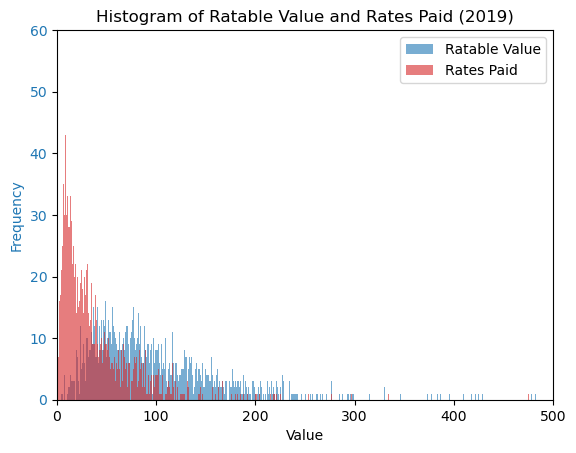

In [44]:
ratable2019 = ratable_value.iloc[:2980, 0]
RatesPaid2019 = RatesPaid.iloc[:2980, 0]
plot_histograms(ratable2019, RatesPaid2019, 2019)

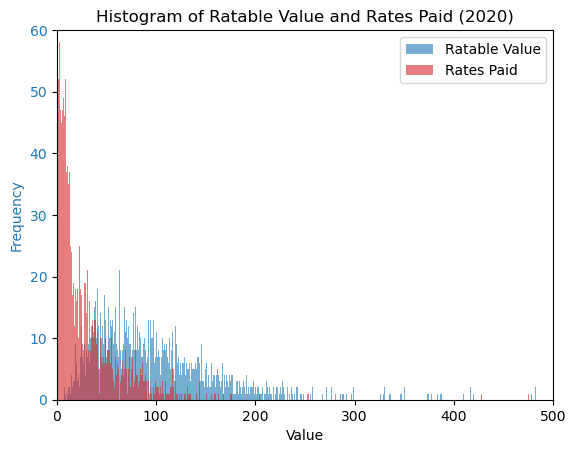

In [45]:
ratable2020 = ratable_value.iloc[:2980, 1]
RatesPaid2020 = RatesPaid.iloc[:2980, 1]
plot_histograms(ratable2020, RatesPaid2020, 2020)

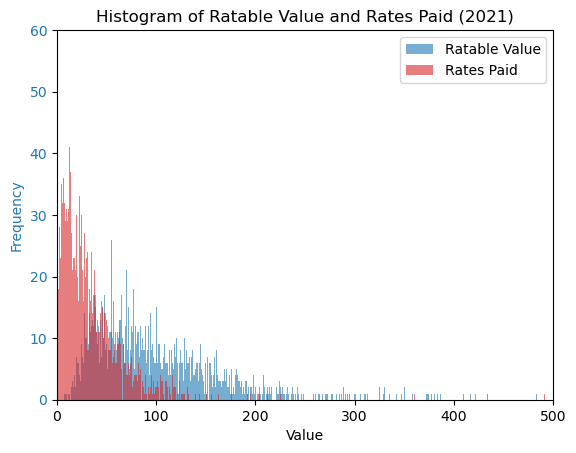

In [46]:
ratable2021 = ratable_value.iloc[:2980, 2]
RatesPaid2021 = RatesPaid.iloc[:2980, 2]
plot_histograms(ratable2021, RatesPaid2021, 2021)

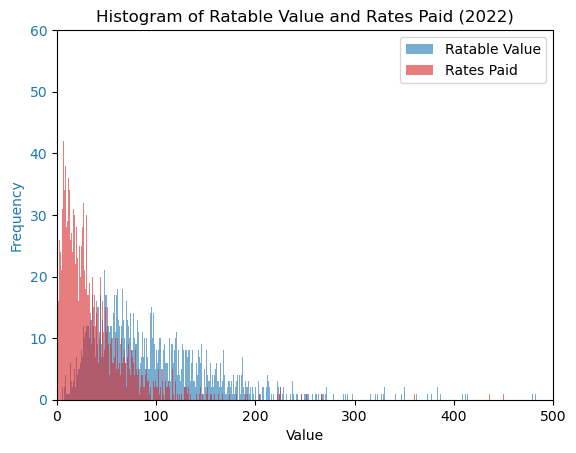

In [47]:
ratable2022 = ratable_value.iloc[:2980, 3]
RatesPaid2022 = RatesPaid.iloc[:2980, 3]
plot_histograms(ratable2022, RatesPaid2022, 2022)

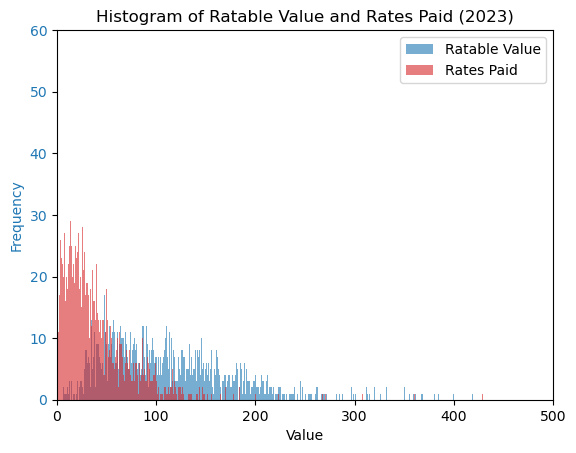

In [48]:
ratable2023 = ratable_value.iloc[:2980, 4]
RatesPaid2023 = RatesPaid.iloc[:2980, 4]
plot_histograms(ratable2023, RatesPaid2023, 2023)

In [49]:
def vacancy_analysis(file_path, filtered_gdf, filtered_voronoi_gdf):
    
    df = pd.read_csv(file_path)
    
    ndf = pd.merge(df, filtered_gdf[['voaUARN', 'geometry']], on='voaUARN', how='left')
    
    ndf_gdf = gpd.GeoDataFrame(ndf, geometry='geometry', crs='EPSG:4326')
    filtered_voronoi_gdf = filtered_voronoi_gdf.set_crs('EPSG:4326')
    
    joined_gdf = gpd.sjoin(ndf_gdf, filtered_voronoi_gdf, how='left', predicate='within')
    ndf['cluster'] = joined_gdf['cluster']
    
    ndf = ndf[ndf['laRatesPaid'] < 0.65 * ndf['voaRateableValue']]
    
    ndf = ndf.dropna(subset=['cluster'])
    
    vacancy = ndf[['cluster', 'voaFloorArea', 'laOccupationState', 'laOccupationStateDate']]
    
    return vacancy

In [50]:
vacancy2019 = vacancy_analysis('data/2019.csv', filtered_gdf, filtered_voronoi_gdf)
vacancy2020 = vacancy_analysis('data/2020.csv', filtered_gdf, filtered_voronoi_gdf)
vacancy2021 = vacancy_analysis('data/2021.csv', filtered_gdf, filtered_voronoi_gdf)
vacancy2022 = vacancy_analysis('data/2022.csv', filtered_gdf, filtered_voronoi_gdf)
vacancy2023 = vacancy_analysis('data/2023.csv', filtered_gdf, filtered_voronoi_gdf)

C:\Users\fengj\AppData\Local\Temp\ipykernel_29248\3829411088.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [51]:
vgroups = [vacancy2019,vacancy2020,vacancy2021,vacancy2022,vacancy2023]
vacancy_state = combine_multiple_columns(vgroups, 'laOccupationState', 'voaFloorArea','cluster')

In [52]:
vacancy_state

,df1_laOccupationState,df2_laOccupationState,df3_laOccupationState,df4_laOccupationState,df5_laOccupationState,df1_voaFloorArea,df2_voaFloorArea,df3_voaFloorArea,df4_voaFloorArea,df5_voaFloorArea,df1_cluster,df2_cluster,df3_cluster,df4_cluster,df5_cluster
1,True,True,NaN,NaN,NaN,428.49,428.49,NaN,NaN,NaN,1232.0,1232.0,NaN,NaN,NaN
2,True,True,NaN,NaN,NaN,326.32,326.32,NaN,NaN,NaN,1232.0,1232.0,NaN,NaN,NaN
3,True,True,NaN,NaN,NaN,84.60,84.60,NaN,NaN,NaN,1566.0,1566.0,NaN,NaN,NaN
4,True,True,NaN,NaN,NaN,41.20,41.20,NaN,NaN,NaN,1384.0,1384.0,NaN,NaN,NaN
5,True,True,NaN,NaN,NaN,67.50,67.50,NaN,NaN,NaN,1372.0,1372.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502372,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,145.88,NaN,NaN,NaN,NaN,3945.0
502436,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,1216.65,NaN,NaN,NaN,NaN,4026.0
502485,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,162.07,NaN,NaN,NaN,NaN,3983.0
502519,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,28.64,NaN,NaN,NaN,NaN,4011.0


In [53]:
def analyze_vacancy_changes(df, col1_index, col2_index, voa_col_index, cluster_col_index):
    # Create a DataFrame to hold results for each cluster
    cluster_results = []

    # Initialize counters for total new vacancies and total new vacancy area
    total_changed_to_false_count = 0
    total_new_vacancy_area = 0

    # Get the unique clusters
    unique_clusters = df.iloc[:, cluster_col_index].unique()

    for cluster in unique_clusters:
        cluster_df = df[df.iloc[:, cluster_col_index] == cluster]

        false_rows = cluster_df[cluster_df.iloc[:, col2_index] == False]
        false_count = len(false_rows)

        changed_to_false = cluster_df[((cluster_df.iloc[:, col1_index] == True) | (cluster_df.iloc[:, col1_index].isna())) & 
                                      (cluster_df.iloc[:, col2_index] == False)]
        changed_to_false_count = len(changed_to_false)
        new_vacancy_area = changed_to_false.iloc[:, voa_col_index].sum()

        total_changed_to_false_count += changed_to_false_count
        total_new_vacancy_area += new_vacancy_area

        cluster_results.append({
            'cluster': cluster,
            'false_count': false_count,
            'changed_to_false_count': changed_to_false_count,
            'new_vacancy_area': new_vacancy_area
        })

    # Convert the results to a DataFrame for easy viewing
    results_df = pd.DataFrame(cluster_results)

    # Print the results for each cluster
    print(results_df)
    
    # Print the total new vacancies and total new vacancy area
    print(f"Total number of new vacancies: {total_changed_to_false_count}")
    print(f"Total voaFloorArea for new vacancies: {total_new_vacancy_area}")

    return results_df, total_changed_to_false_count, total_new_vacancy_area

In [54]:
results_df2020, total_changes, total_area = analyze_vacancy_changes(
    df=vacancy_state,
    col1_index=0,
    col2_index=1,
    voa_col_index=6,
    cluster_col_index=11
)

      cluster  false_count  changed_to_false_count  new_vacancy_area
0      1232.0            4                       2            822.78
1      1566.0            8                       3            524.73
2      1384.0            2                       1            130.60
3      1372.0            2                       2            234.92
4      1596.0           70                      52           8683.89
...       ...          ...                     ...               ...
2839   4010.0            1                       1             67.83
2840   3553.0            3                       3            102.10
2841   4401.0            0                       0              0.00
2842   4408.0            0                       0              0.00
2843   4412.0            0                       0              0.00

[2844 rows x 4 columns]
Total number of new vacancies: 13291
Total voaFloorArea for new vacancies: 2178907.680000003


In [55]:
results_df2021, total_changes, total_area = analyze_vacancy_changes(
    df=vacancy_state,
    col1_index=1,
    col2_index=2,
    voa_col_index=7,
    cluster_col_index=12
)

      cluster  false_count  changed_to_false_count  new_vacancy_area
0         NaN            0                       0              0.00
1       369.0            2                       0              0.00
2       551.0           19                       0              0.00
3       368.0            4                       0              0.00
4       319.0           23                       1            262.26
...       ...          ...                     ...               ...
2872   4010.0            1                       1             67.83
2873   3553.0            1                       1             50.90
2874   4408.0            0                       0              0.00
2875   4412.0            0                       0              0.00
2876   4414.0            1                       1              0.00

[2877 rows x 4 columns]
Total number of new vacancies: 15497
Total voaFloorArea for new vacancies: 2528112.0800000005


In [56]:
results_df2022, total_changes, total_area = analyze_vacancy_changes(
    df=vacancy_state,
    col1_index=2,
    col2_index=3,
    voa_col_index=8,
    cluster_col_index=13
)

      cluster  false_count  changed_to_false_count  new_vacancy_area
0         NaN            0                       0              0.00
1       369.0            4                       4            404.22
2       551.0           24                      17           3989.97
3       368.0            4                       0              0.00
4       319.0           32                      18           4050.48
...       ...          ...                     ...               ...
3011   3553.0            2                       2            102.10
3012   4408.0            0                       0              0.00
3013   4412.0            0                       0              0.00
3014   4407.0            0                       0              0.00
3015   4414.0            0                       0              0.00

[3016 rows x 4 columns]
Total number of new vacancies: 16099
Total voaFloorArea for new vacancies: 2662210.98


In [57]:
results_df2023, total_changes, total_area = analyze_vacancy_changes(
    df=vacancy_state,
    col1_index=3,
    col2_index=4,
    voa_col_index=9,
    cluster_col_index=14
)

      cluster  false_count  changed_to_false_count  new_vacancy_area
0         NaN            0                       0              0.00
1       369.0            4                       0              0.00
2       551.0           25                       7           2524.01
3       368.0            7                       3            134.84
4       319.0           25                       5           1271.30
...       ...          ...                     ...               ...
2566   3974.0            0                       0              0.00
2567   4013.0            1                       1            460.93
2568   4010.0            0                       0              0.00
2569   3553.0            3                       3            159.41
2570   4421.0            0                       0              0.00

[2571 rows x 4 columns]
Total number of new vacancies: 17454
Total voaFloorArea for new vacancies: 2953923.880000002


In [58]:
business_longevity = combine_multiple_columns(vgroups,'laOccupationStateDate','cluster')
business_longevity = business_longevity.dropna(how='all')
business_longevity

,df1_laOccupationStateDate,df2_laOccupationStateDate,df3_laOccupationStateDate,df4_laOccupationStateDate,df5_laOccupationStateDate,df1_cluster,df2_cluster,df3_cluster,df4_cluster,df5_cluster
1,2014-07-01,2014-07-01,NaN,NaN,NaN,1232.0,1232.0,NaN,NaN,NaN
2,2018-02-16,2018-02-16,NaN,NaN,NaN,1232.0,1232.0,NaN,NaN,NaN
3,2015-09-27,2015-09-27,NaN,NaN,NaN,1566.0,1566.0,NaN,NaN,NaN
4,2007-08-20,2007-08-20,NaN,NaN,NaN,1384.0,1384.0,NaN,NaN,NaN
5,2019-06-03,2019-06-03,NaN,NaN,NaN,1372.0,1372.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
502372,NaN,NaN,NaN,NaN,2023-10-01,NaN,NaN,NaN,NaN,3945.0
502436,NaN,NaN,NaN,NaN,2023-10-01,NaN,NaN,NaN,NaN,4026.0
502485,NaN,NaN,NaN,NaN,2023-10-01,NaN,NaN,NaN,NaN,3983.0
502519,NaN,NaN,NaN,NaN,2023-10-01,NaN,NaN,NaN,NaN,4011.0


In [59]:
business_longevity['df1_laOccupationStateDate'] = pd.to_datetime(business_longevity['df1_laOccupationStateDate'], errors='coerce')
business_longevity['df2_laOccupationStateDate'] = pd.to_datetime(business_longevity['df2_laOccupationStateDate'], errors='coerce')
business_longevity['df3_laOccupationStateDate'] = pd.to_datetime(business_longevity['df3_laOccupationStateDate'], errors='coerce')
business_longevity['df4_laOccupationStateDate'] = pd.to_datetime(business_longevity['df4_laOccupationStateDate'], errors='coerce')
business_longevity['df5_laOccupationStateDate'] = pd.to_datetime(business_longevity['df5_laOccupationStateDate'], errors='coerce')

df2_cluster
3.0        442.500000
8.0        400.000000
9.0        859.000000
20.0       549.666667
34.0      1423.000000
             ...     
4151.0    1801.000000
4160.0    1473.000000
4166.0    1422.600000
4175.0    1897.000000
4406.0    5898.000000
Name: days_difference, Length: 661, dtype: float64


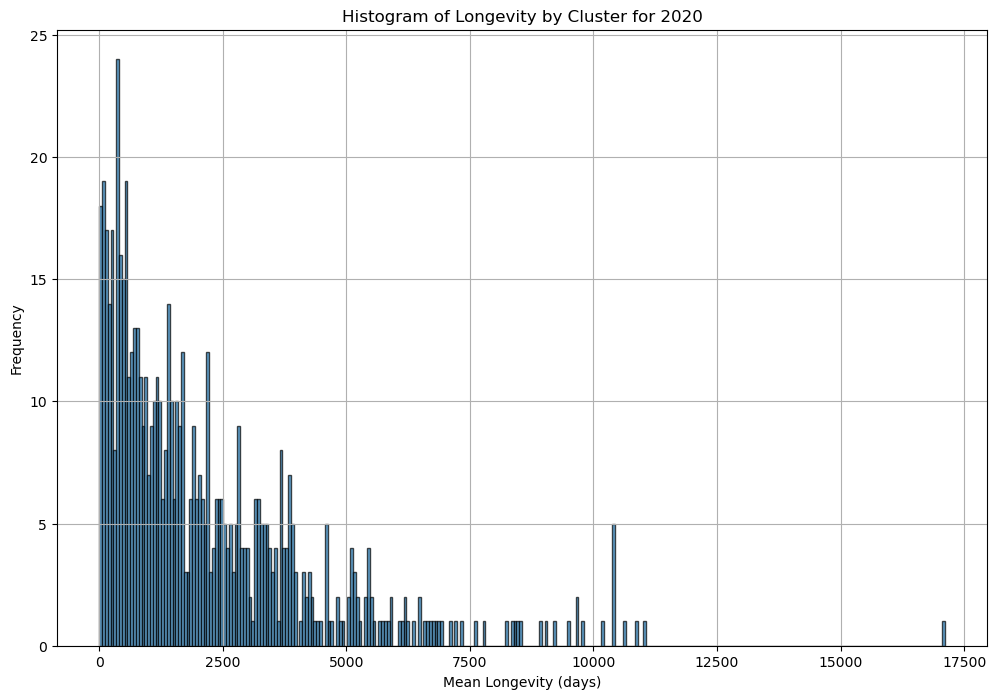

In [60]:
shutdown_2020 = vacancy_state[((vacancy_state.iloc[:, 0] == True)) & (vacancy_state.iloc[:, 1] == False)].index

longevity2020 = business_longevity.loc[shutdown_2020]

longevity2020['df1_laOccupationStateDate'] = pd.to_datetime(longevity2020['df1_laOccupationStateDate'])
longevity2020['df2_laOccupationStateDate'] = pd.to_datetime(longevity2020['df2_laOccupationStateDate'])

longevity2020['date_difference'] = longevity2020['df2_laOccupationStateDate'] - longevity2020['df1_laOccupationStateDate']
longevity2020['days_difference'] = longevity2020['date_difference'].dt.days

cluster_col_index = 6  
longevity_by_cluster2020 = longevity2020.groupby(longevity2020.iloc[:, cluster_col_index])['days_difference'].mean()

longevity_by_cluster2020 = longevity_by_cluster2020[longevity_by_cluster2020 >= 0]

print(longevity_by_cluster2020)

plt.figure(figsize=(12, 8))
plt.hist(longevity_by_cluster2020, bins=300, edgecolor='black', alpha=0.7)
plt.title('Histogram of Longevity by Cluster for 2020')
plt.xlabel('Mean Longevity (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df3_cluster
3.0        1704.0
8.0        1178.0
9.0        6112.0
15.0       7663.0
20.0       2525.0
           ...   
4388.0     4799.0
4392.0    10227.0
4397.0     3386.0
4405.0     3315.5
4406.0     3346.5
Name: days_difference, Length: 722, dtype: float64


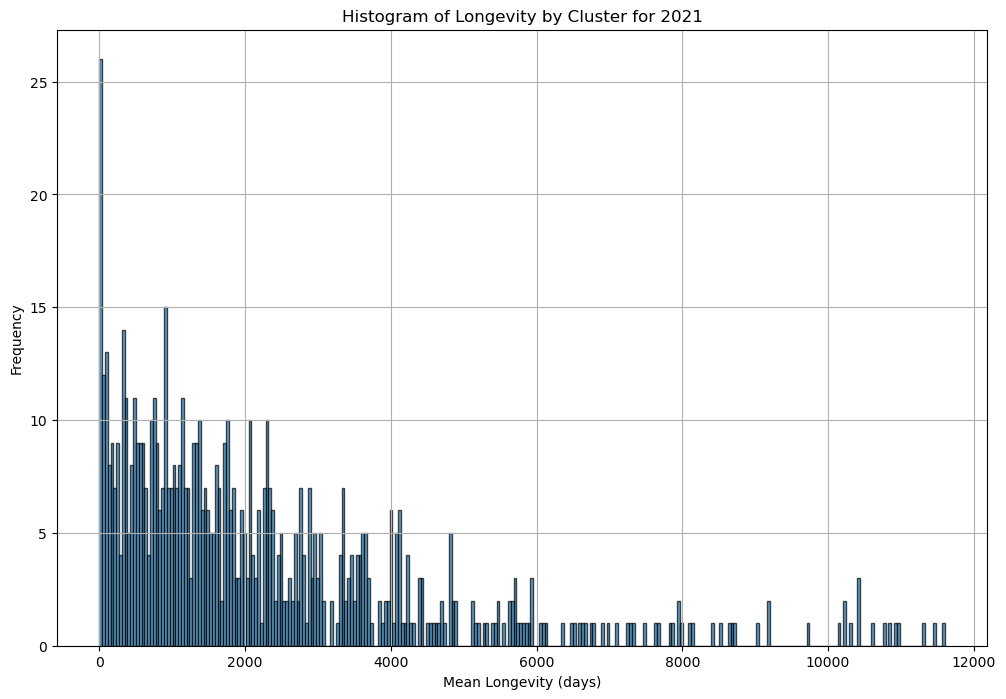

In [61]:
shutdown_2021 = vacancy_state[((vacancy_state.iloc[:, 1] == True)) & (vacancy_state.iloc[:, 2] == False)].index

longevity2021 = business_longevity.loc[shutdown_2021]

longevity2021['df2_laOccupationStateDate'] = pd.to_datetime(longevity2021['df2_laOccupationStateDate'])
longevity2021['df3_laOccupationStateDate'] = pd.to_datetime(longevity2021['df3_laOccupationStateDate'])

longevity2021['date_difference'] = longevity2021['df3_laOccupationStateDate'] - longevity2021['df2_laOccupationStateDate']

longevity2021['days_difference'] = longevity2021['date_difference'].dt.days

cluster_col_index = 7  
longevity_by_cluster2021 = longevity2021.groupby(longevity2021.iloc[:, cluster_col_index])['days_difference'].mean()

longevity_by_cluster2021 = longevity_by_cluster2021[longevity_by_cluster2021 >= 0]

print(longevity_by_cluster2021)

plt.figure(figsize=(12, 8))
plt.hist(longevity_by_cluster2021, bins=300, edgecolor='black', alpha=0.7)
plt.title('Histogram of Longevity by Cluster for 2021')
plt.xlabel('Mean Longevity (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df4_cluster
5.0       1017.000000
9.0       1960.000000
26.0      1918.000000
34.0      1768.222222
35.0      2434.000000
             ...     
4150.0    3182.181818
4153.0    1727.000000
4156.0    1256.000000
4159.0    5511.000000
4355.0    1253.000000
Name: days_difference, Length: 828, dtype: float64


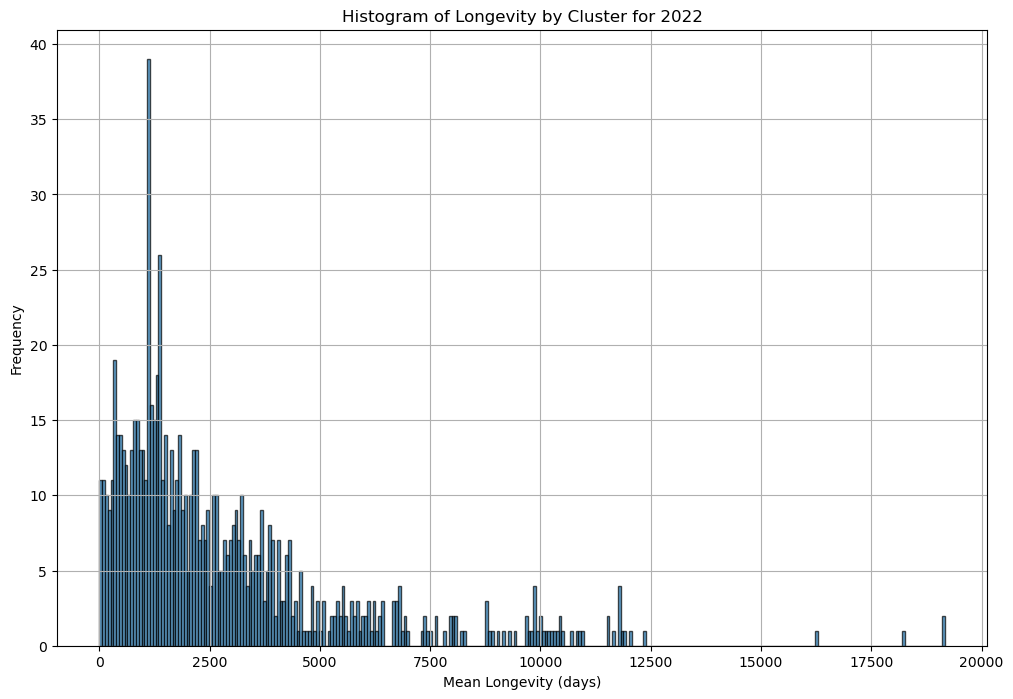

In [62]:
shutdown_2022 = vacancy_state[((vacancy_state.iloc[:, 2] == True)) & (vacancy_state.iloc[:, 3] == False)].index

longevity2022 = business_longevity.loc[shutdown_2022]

longevity2022['df3_laOccupationStateDate'] = pd.to_datetime(longevity2022['df3_laOccupationStateDate'])
longevity2022['df4_laOccupationStateDate'] = pd.to_datetime(longevity2022['df4_laOccupationStateDate'])

longevity2022['date_difference'] = longevity2022['df4_laOccupationStateDate'] - longevity2022['df3_laOccupationStateDate']

longevity2022['days_difference'] = longevity2022['date_difference'].dt.days

cluster_col_index = 8  
longevity_by_cluster2022 = longevity2022.groupby(longevity2022.iloc[:, cluster_col_index])['days_difference'].mean()

longevity_by_cluster2022 = longevity_by_cluster2022[longevity_by_cluster2022 >= 0]

print(longevity_by_cluster2022)

plt.figure(figsize=(12, 8))
plt.hist(longevity_by_cluster2022, bins=300, edgecolor='black', alpha=0.7)
plt.title('Histogram of Longevity by Cluster for 2022')
plt.xlabel('Mean Longevity (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df5_cluster
3.0       4475.000000
20.0      5632.000000
70.0      2663.362069
99.0      1207.000000
129.0     3264.000000
             ...     
4366.0    3990.450000
4371.0    3231.142857
4388.0    3721.111111
4393.0     548.000000
4406.0    3829.230769
Name: days_difference, Length: 738, dtype: float64


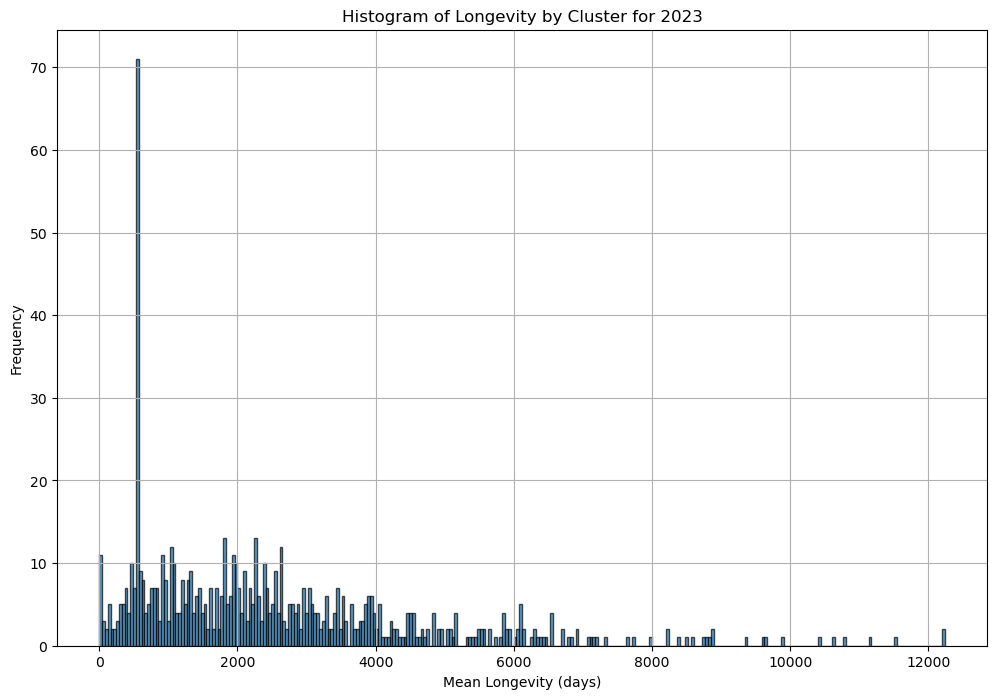

In [63]:
shutdown_2023 = vacancy_state[((vacancy_state.iloc[:, 3] == True)) & (vacancy_state.iloc[:, 4] == False)].index

longevity2023 = business_longevity.loc[shutdown_2023]

longevity2023['df4_laOccupationStateDate'] = pd.to_datetime(longevity2023['df4_laOccupationStateDate'])
longevity2023['df5_laOccupationStateDate'] = pd.to_datetime(longevity2023['df5_laOccupationStateDate'])

longevity2023['date_difference'] = longevity2023['df5_laOccupationStateDate'] - longevity2023['df4_laOccupationStateDate']

longevity2023['days_difference'] = longevity2023['date_difference'].dt.days

cluster_col_index = 9  
longevity_by_cluster2023 = longevity2023.groupby(longevity2023.iloc[:, cluster_col_index])['days_difference'].mean()

longevity_by_cluster2023 = longevity_by_cluster2023[longevity_by_cluster2023 >= 0]

print(longevity_by_cluster2023)

plt.figure(figsize=(12, 8))
plt.hist(longevity_by_cluster2023, bins=300, edgecolor='black', alpha=0.7)
plt.title('Histogram of Longevity by Cluster for 2023')
plt.xlabel('Mean Longevity (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

          2020  df2_retail_ratio  df2_cluster  df2_voaFloorArea  false_count  \
0     0.000000          1.000000          1.0             75.70            0   
1     0.380329          0.839116          3.0           1891.55            2   
2     0.173268          0.996980          4.0           1324.41            0   
3     0.068438          0.968212          5.0           1733.35            0   
4     0.355591          0.611499          7.0           2042.93            0   
...        ...               ...          ...               ...          ...   
2975       NaN               NaN          NaN               NaN            0   
2976       NaN               NaN          NaN               NaN            0   
2977       NaN               NaN          NaN               NaN            0   
2978       NaN               NaN          NaN               NaN            0   
2979       NaN               NaN          NaN               NaN            0   

      changed_to_false_count  new_vacan

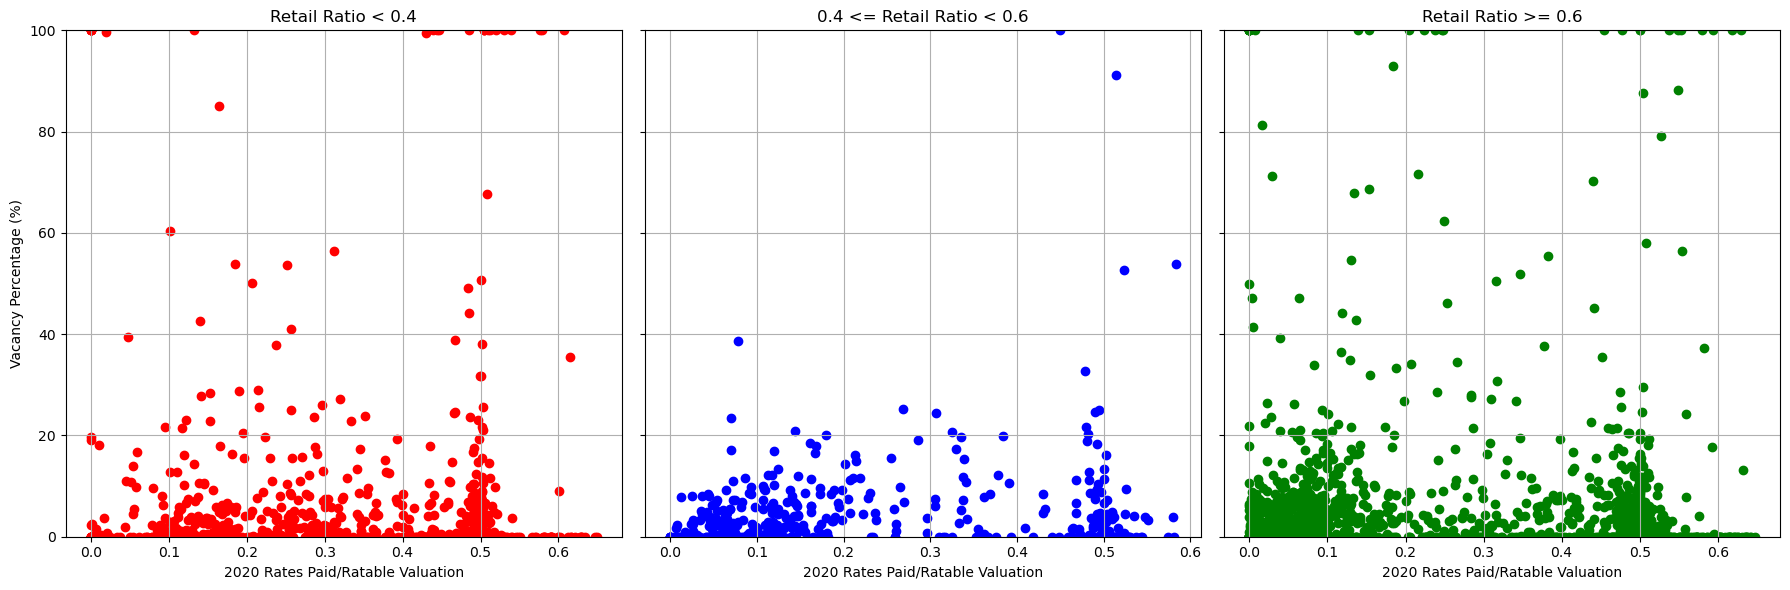

In [64]:
adv_rate_relief2020 = adv_rate_relief[['2020', 'df2_retail_ratio', 'df2_cluster', 'df2_voaFloorArea']]
results_df2020.rename(columns={'cluster': 'df2_cluster'}, inplace=True)
vacancies2020 = pd.merge(adv_rate_relief2020, results_df2020, on='df2_cluster', how='inner')

vacancies2020['vacancy_percentage'] = (vacancies2020['new_vacancy_area'] / vacancies2020['df2_voaFloorArea']) * 100

print(vacancies2020)

vacancies2020['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in vacancies2020['df2_retail_ratio']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Red points (df2_retail_ratio < 0.4)
red_points = vacancies2020[vacancies2020['color'] == 'red']
axes[0].scatter(red_points['2020'], red_points['vacancy_percentage'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2020 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('Vacancy Percentage (%)')
axes[0].set_ylim(0, 100)
axes[0].grid(True)

# Blue points (0.4 <= df2_retail_ratio < 0.6)
blue_points = vacancies2020[vacancies2020['color'] == 'blue']
axes[1].scatter(blue_points['2020'], blue_points['vacancy_percentage'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2020 Rates Paid/Ratable Valuation')
axes[1].set_ylim(0, 100)
axes[1].grid(True)

# Yellow points (0.6 <= df2_retail_ratio <= 1.0)
yellow_points = vacancies2020[vacancies2020['color'] == 'green']
axes[2].scatter(yellow_points['2020'], yellow_points['vacancy_percentage'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2020 Rates Paid/Ratable Valuation')
axes[2].set_ylim(0, 100)
axes[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [65]:
completly_vacant2020 = vacancies2020[vacancies2020['vacancy_percentage'] == 100]

completly_vacant2020_floor_area_sum = completly_vacant2020['df2_voaFloorArea'].sum()

vacancies2020_floor_area_sum = vacancies2020['df2_voaFloorArea'].sum()

percentage2020 = (completly_vacant2020_floor_area_sum / vacancies2020_floor_area_sum) * 100

print(f"The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2020 is: {percentage2020:.2f}%")

The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2020 is: 0.04%


          2021  df3_retail_ratio  df3_cluster  df3_voaFloorArea  false_count  \
0     0.000000          0.974260          1.0             77.70            0   
1     0.429319          0.839116          3.0           1891.55            2   
2     0.256076          0.996980          4.0           1324.41            0   
3     0.499000          0.634216          5.0            139.70            0   
4     0.093159          0.763913          6.0           3243.93            0   
...        ...               ...          ...               ...          ...   
2975       NaN               NaN          NaN               NaN            0   
2976       NaN               NaN          NaN               NaN            0   
2977       NaN               NaN          NaN               NaN            0   
2978       NaN               NaN          NaN               NaN            0   
2979       NaN               NaN          NaN               NaN            0   

      changed_to_false_count  new_vacan

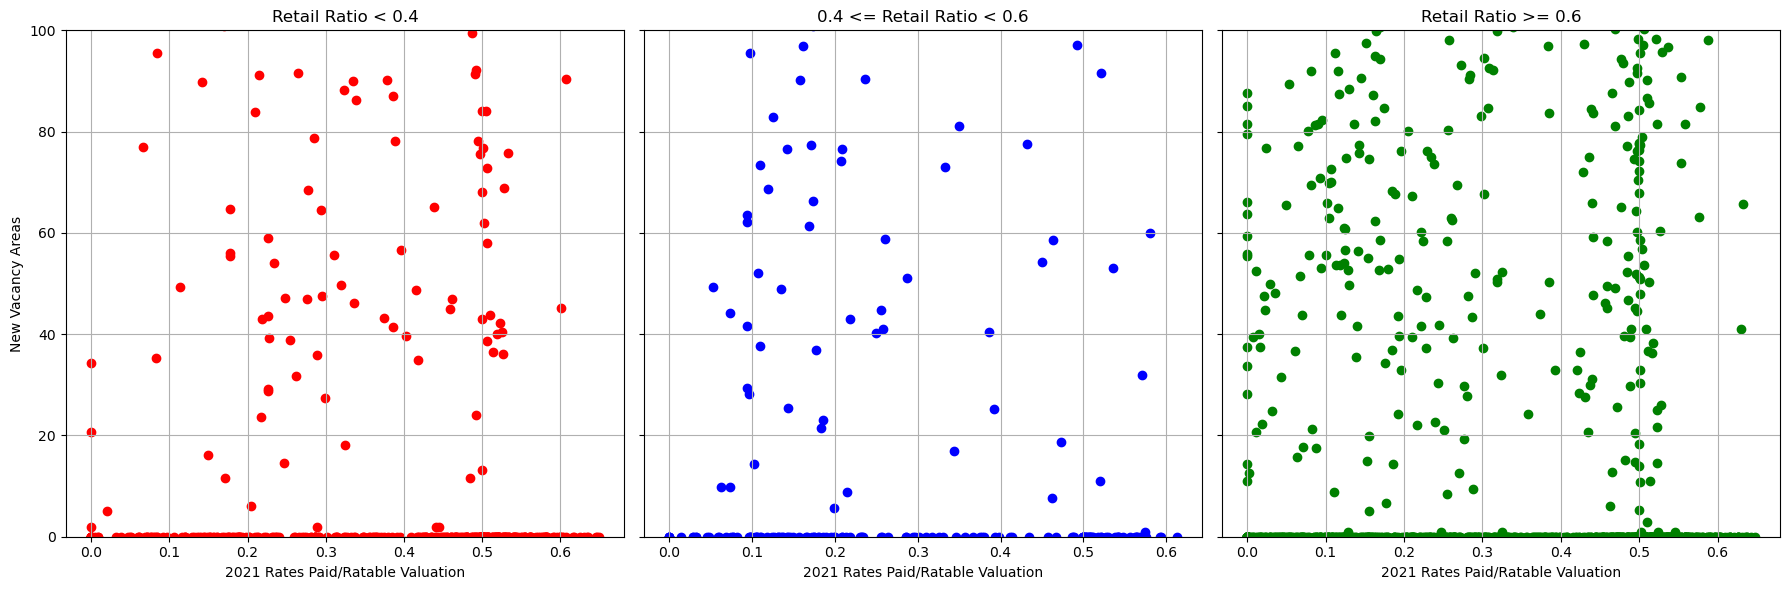

In [66]:
adv_rate_relief2021 = adv_rate_relief[['2021', 'df3_retail_ratio', 'df3_cluster','df3_voaFloorArea']]
results_df2021.rename(columns={'cluster': 'df3_cluster'}, inplace=True)
vacancies2021 = pd.merge(adv_rate_relief2021, results_df2021, on='df3_cluster', how='inner')
vacancies2021['vacancy_percentage'] = (vacancies2021['new_vacancy_area'] / vacancies2021['df3_voaFloorArea']) * 100
print(vacancies2021)

vacancies2021['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in vacancies2021['df3_retail_ratio']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Red points (df3_retail_ratio < 0.4)
red_points = vacancies2021[vacancies2021['color'] == 'red']
axes[0].scatter(red_points['2021'], red_points['new_vacancy_area'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2021 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('New Vacancy Areas')
axes[0].set_ylim(0, 100)
axes[0].grid(True)

# Blue points (0.4 <= df3_retail_ratio < 0.6)
blue_points = vacancies2021[vacancies2021['color'] == 'blue']
axes[1].scatter(blue_points['2021'], blue_points['new_vacancy_area'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2021 Rates Paid/Ratable Valuation')
axes[1].set_ylim(0, 100)
axes[1].grid(True)

# Yellow points (0.6 <= df3_retail_ratio <= 1.0)
yellow_points = vacancies2021[vacancies2021['color'] == 'green']
axes[2].scatter(yellow_points['2021'], yellow_points['new_vacancy_area'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2021 Rates Paid/Ratable Valuation')
axes[2].set_ylim(0, 100)
axes[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [67]:
completly_vacant2021 = vacancies2021[vacancies2021['vacancy_percentage'] == 100]

completly_vacant2021_floor_area_sum = completly_vacant2021['df3_voaFloorArea'].sum()

vacancies2021_floor_area_sum = vacancies2021['df3_voaFloorArea'].sum()

percentage2021 = (completly_vacant2021_floor_area_sum / vacancies2021_floor_area_sum) * 100

print(f"The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2021 is: {percentage2021:.2f}%")

The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2021 is: 0.04%


          2022  df4_retail_ratio  df4_cluster  df4_voaFloorArea  false_count  \
0     0.000000          0.000000            1              2.00            0   
1     0.350147          0.782060            3           2029.55            1   
2     0.216150          0.996980            4           1324.41            0   
3     0.163412          0.625064            5           3322.78            2   
4     0.081466          0.900207            6           1611.93            0   
...        ...               ...          ...               ...          ...   
2975  0.479532          0.000000         4408            401.00            0   
2976  0.427835          1.000000         4412            168.12            0   
2977  0.435961          0.996610         4421            294.98            0   
2978  0.095000          0.000000         4422              2.00            0   
2979  0.391089          0.926740         4425             27.30            0   

      changed_to_false_count  new_vacan

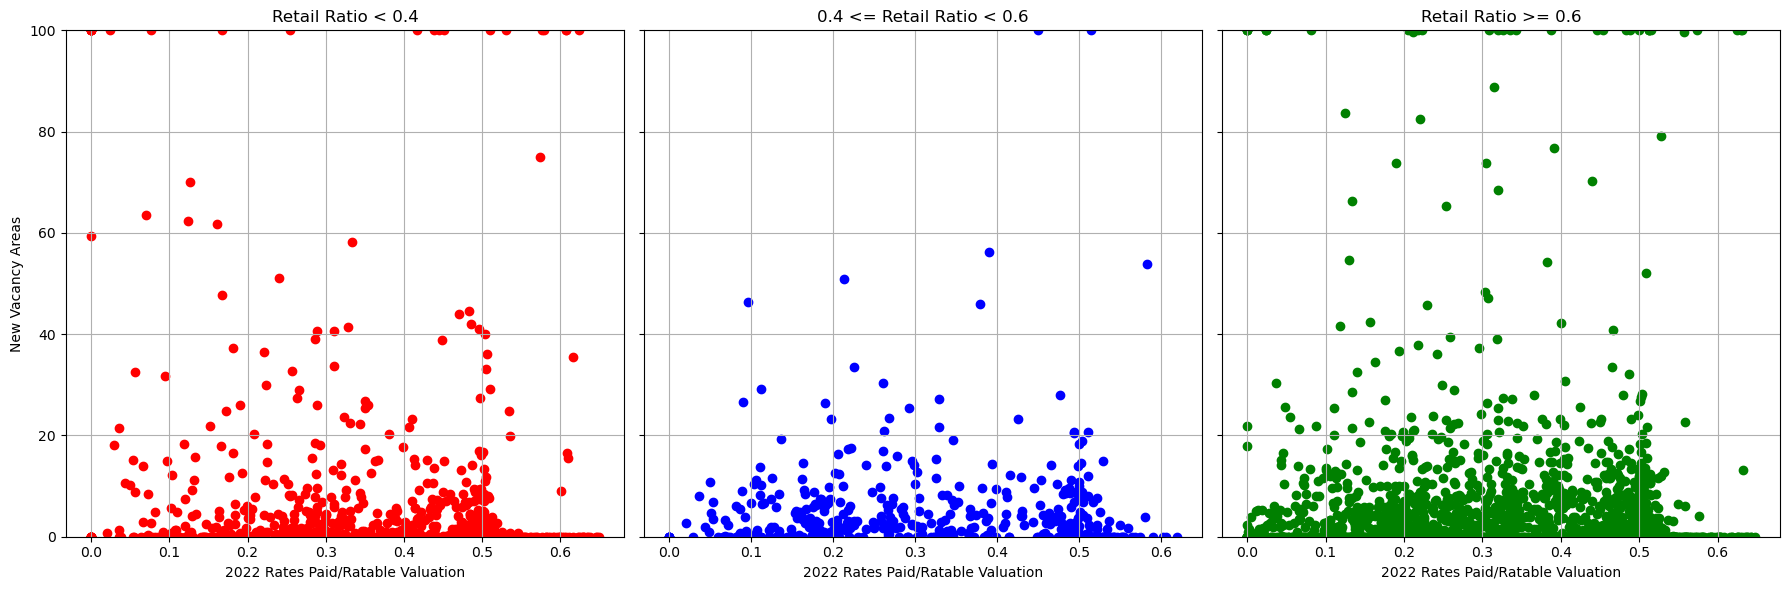

In [68]:
adv_rate_relief2022 = adv_rate_relief[['2022','df4_retail_ratio', 'df4_cluster', 'df4_voaFloorArea']]
results_df2022.rename(columns={'cluster': 'df4_cluster'}, inplace=True)
vacancies2022 = pd.merge(adv_rate_relief2022, results_df2022, on='df4_cluster', how='inner')
vacancies2022['vacancy_percentage'] = (vacancies2022['new_vacancy_area'] / vacancies2022['df4_voaFloorArea']) * 100
print(vacancies2022)

vacancies2022['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in vacancies2022['df4_retail_ratio']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Red points (df4_retail_ratio < 0.4)
red_points = vacancies2022[vacancies2022['color'] == 'red']
axes[0].scatter(red_points['2022'], red_points['vacancy_percentage'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2022 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('New Vacancy Areas')
axes[0].set_ylim(0, 100)
axes[0].grid(True)

# Blue points (0.4 <= df4_retail_ratio < 0.6)
blue_points = vacancies2022[vacancies2022['color'] == 'blue']
axes[1].scatter(blue_points['2022'], blue_points['vacancy_percentage'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2022 Rates Paid/Ratable Valuation')
axes[1].set_ylim(0, 100)
axes[1].grid(True)

# Yellow points (0.6 <= df4_retail_ratio <= 1.0)
yellow_points = vacancies2022[vacancies2022['color'] == 'green']
axes[2].scatter(yellow_points['2022'], yellow_points['vacancy_percentage'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2022 Rates Paid/Ratable Valuation')
axes[2].set_ylim(0, 100)
axes[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [69]:
completly_vacant2022 = vacancies2022[vacancies2022['vacancy_percentage'] == 100]

completly_vacant2022_floor_area_sum = completly_vacant2022['df4_voaFloorArea'].sum()

vacancies2022_floor_area_sum = vacancies2022['df4_voaFloorArea'].sum()

percentage2022 = (completly_vacant2022_floor_area_sum / vacancies2022_floor_area_sum) * 100

print(f"The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2022 is: {percentage2022:.2f}%")

The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2022 is: 0.04%


          2023  df5_retail_ratio  df5_cluster  df5_voaFloorArea  false_count  \
0     0.504483          0.826015          3.0           1921.55            1   
1     0.511050          0.998488          4.0           1322.41            0   
2     0.437640          0.752658          5.0            921.80            0   
3     0.445468          0.636705          7.0           2281.01            0   
4     0.497744          0.338681          8.0           7154.97            0   
...        ...               ...          ...               ...          ...   
2975       NaN               NaN          NaN               NaN            0   
2976       NaN               NaN          NaN               NaN            0   
2977       NaN               NaN          NaN               NaN            0   
2978       NaN               NaN          NaN               NaN            0   
2979       NaN               NaN          NaN               NaN            0   

      changed_to_false_count  new_vacan

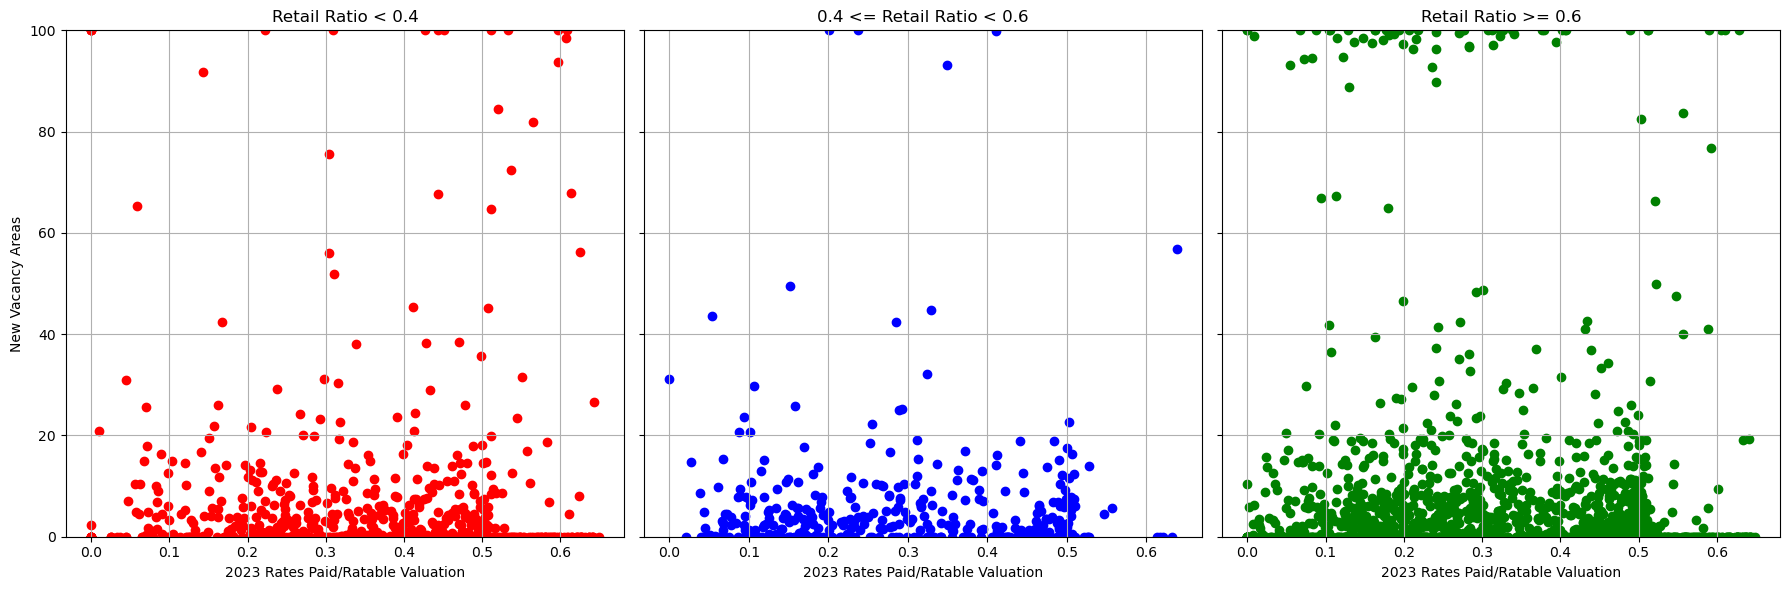

In [70]:
adv_rate_relief2023 = adv_rate_relief[['2023', 'df5_retail_ratio', 'df5_cluster', 'df5_voaFloorArea']]
results_df2023.rename(columns={'cluster': 'df5_cluster'}, inplace=True)
vacancies2023 = pd.merge(adv_rate_relief2023, results_df2023, on='df5_cluster', how='inner')
vacancies2023['vacancy_percentage'] = (vacancies2023['new_vacancy_area'] / vacancies2023['df5_voaFloorArea']) * 100
print(vacancies2023)

vacancies2023['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in vacancies2023['df5_retail_ratio']]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Red points (df5_retail_ratio < 0.4)
red_points = vacancies2023[vacancies2023['color'] == 'red']
axes[0].scatter(red_points['2023'], red_points['vacancy_percentage'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2023 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('New Vacancy Areas')
axes[0].set_ylim(0, 100)
axes[0].grid(True)

# Blue points (0.4 <= df5_retail_ratio < 0.6)
blue_points = vacancies2023[vacancies2023['color'] == 'blue']
axes[1].scatter(blue_points['2023'], blue_points['vacancy_percentage'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2023 Rates Paid/Ratable Valuation')
axes[1].set_ylim(0, 100)
axes[1].grid(True)

# Yellow points (0.6 <= df5_retail_ratio <= 1.0)
yellow_points = vacancies2023[vacancies2023['color'] == 'green']
axes[2].scatter(yellow_points['2023'], yellow_points['vacancy_percentage'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2023 Rates Paid/Ratable Valuation')
axes[2].set_ylim(0, 100)
axes[2].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [71]:
completly_vacant2023 = vacancies2023[vacancies2023['vacancy_percentage'] == 100]

completly_vacant2023_floor_area_sum = completly_vacant2023['df5_voaFloorArea'].sum()

vacancies2023_floor_area_sum = vacancies2023['df5_voaFloorArea'].sum()

percentage2023 = (completly_vacant2023_floor_area_sum / vacancies2023_floor_area_sum) * 100

print(f"The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2023 is: {percentage2023:.2f}%")

The percentage of the completly vacant cluster floor area sum to the total vacancy floor area in 2023 is: 0.20%


         2020  df2_retail_ratio  df2_cluster  days_difference
0    0.380329          0.839116          3.0       442.500000
1    0.399342          0.292735          8.0       400.000000
2    0.249845          0.690060          9.0       859.000000
3    0.457744          0.076447         20.0       549.666667
4    0.501055          0.652166         34.0      1423.000000
..        ...               ...          ...              ...
656  0.059066          0.720881       4151.0      1801.000000
657  0.501869          0.668965       4160.0      1473.000000
658  0.092918          0.917595       4166.0      1422.600000
659  0.045729          0.903160       4175.0      1897.000000
660  0.003032          0.977734       4406.0      5898.000000

[661 rows x 4 columns]
2169.7423897267604


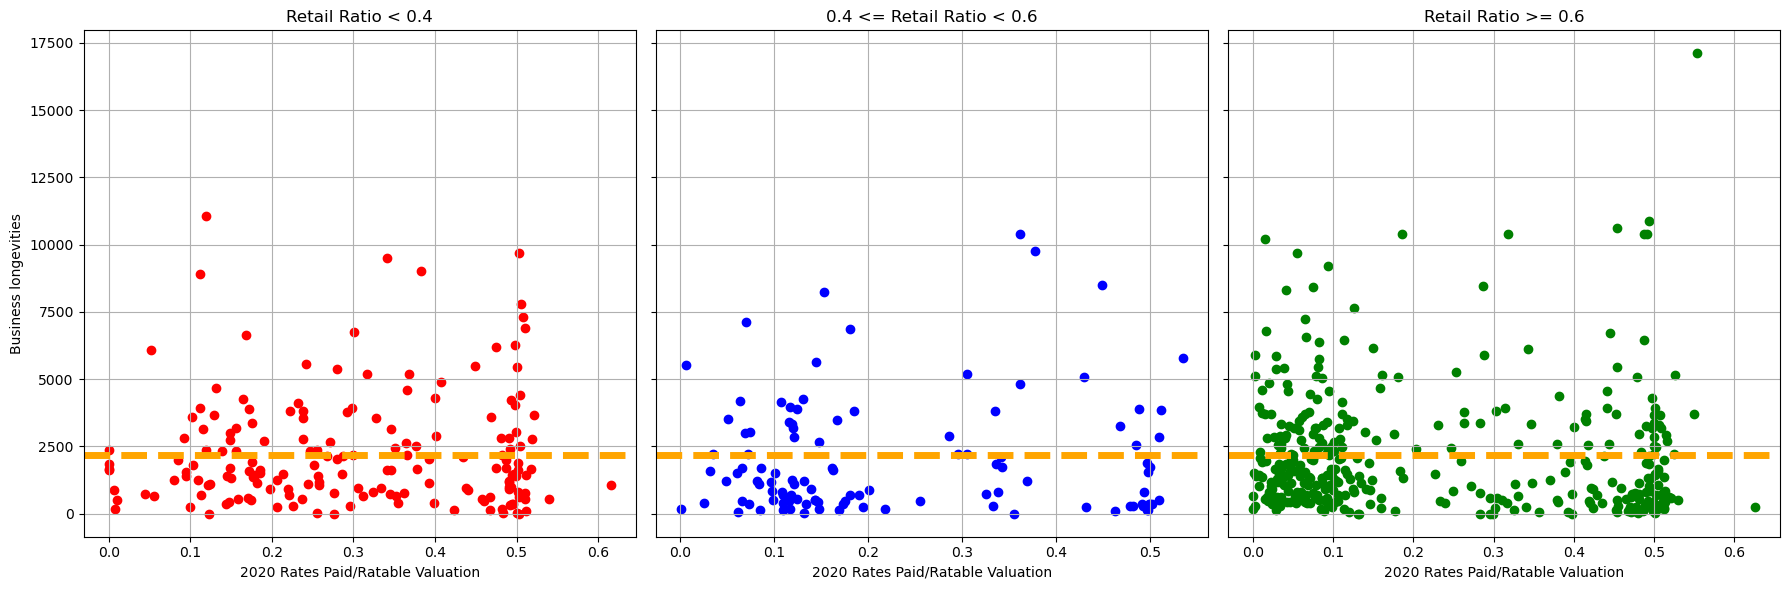

In [72]:
adv_rate_relief2020 = adv_rate_relief[['2020', 'df2_retail_ratio', 'df2_cluster']]
longevities2020 = pd.merge(adv_rate_relief2020, longevity_by_cluster2020, on='df2_cluster', how='inner')

print(longevities2020)

longevities2020['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in longevities2020['df2_retail_ratio']]

average_days_difference2020 = longevities2020['days_difference'].mean()
print (average_days_difference2020)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

red_points = longevities2020[longevities2020['color'] == 'red']
axes[0].scatter(red_points['2020'], red_points['days_difference'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2020 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('Business longevities')
axes[0].grid(True)
axes[0].axhline(average_days_difference2020, color='orange', linestyle='--', linewidth=5, label='Average longevity')

blue_points = longevities2020[longevities2020['color'] == 'blue']
axes[1].scatter(blue_points['2020'], blue_points['days_difference'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2020 Rates Paid/Ratable Valuation')
axes[1].grid(True)
axes[1].axhline(average_days_difference2020, color='orange', linestyle='--', linewidth=5, label='Average longevity')

yellow_points = longevities2020[longevities2020['color'] == 'green']
axes[2].scatter(yellow_points['2020'], yellow_points['days_difference'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2020 Rates Paid/Ratable Valuation')
axes[2].grid(True)
axes[2].axhline(average_days_difference2020, color='orange', linestyle='--', linewidth=5, label='Average longevity')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

         2021  df3_retail_ratio  df3_cluster  days_difference
0    0.429319          0.839116          3.0           1704.0
1    0.451773          0.296046          8.0           1178.0
2    0.280484          0.702263          9.0           6112.0
3    0.071122          0.996501         15.0           7663.0
4    0.475344          0.076447         20.0           2525.0
..        ...               ...          ...              ...
717  0.505278          0.426796       4388.0           4799.0
718  0.204290          1.000000       4392.0          10227.0
719  0.521230          0.514594       4397.0           3386.0
720  0.525993          0.164099       4405.0           3315.5
721  0.468377          0.286577       4406.0           3346.5

[722 rows x 4 columns]
2292.184241900078


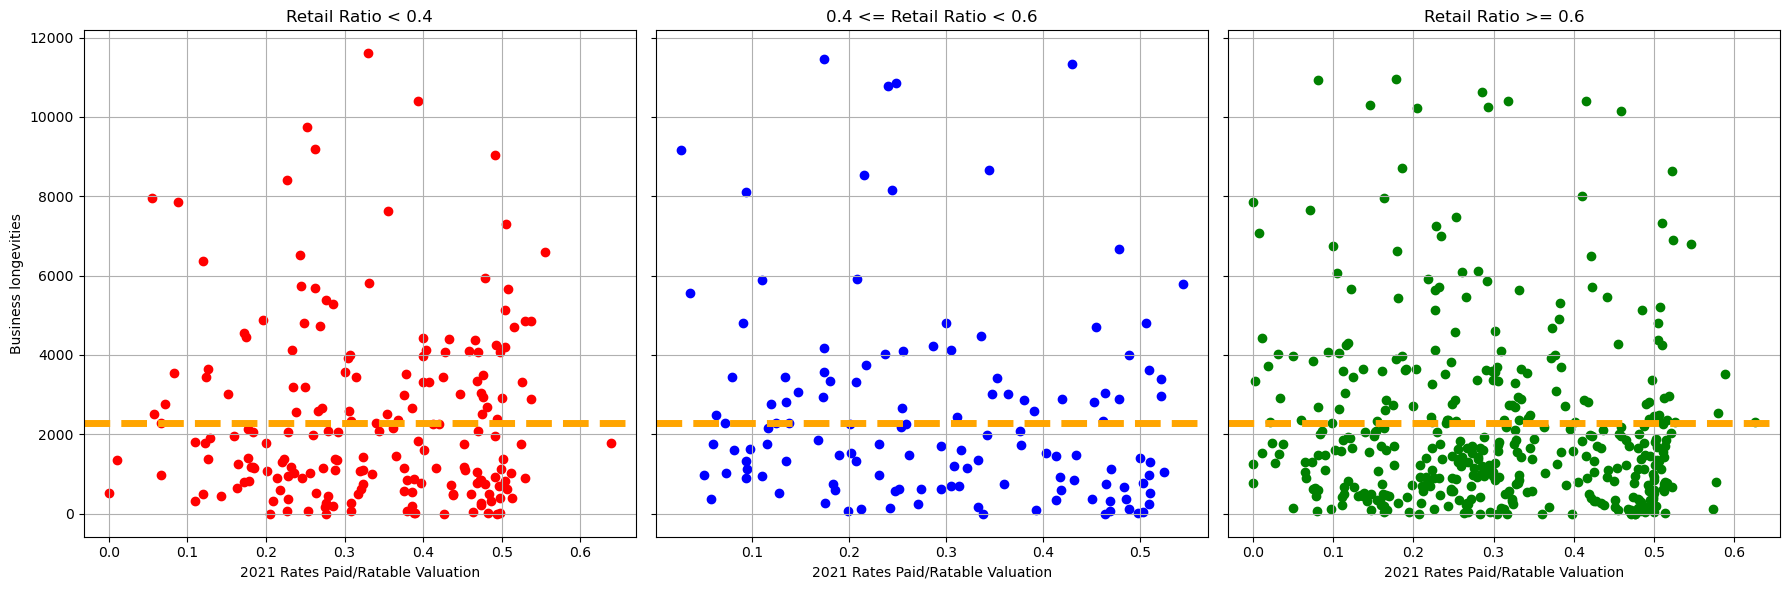

In [73]:
adv_rate_relief2021 = adv_rate_relief[['2021', 'df3_retail_ratio', 'df3_cluster']]
longevities2021 = pd.merge(adv_rate_relief2021, longevity_by_cluster2021, on='df3_cluster', how='inner')

print(longevities2021)

longevities2021['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in longevities2021['df3_retail_ratio']]

average_days_difference2021 = longevities2021['days_difference'].mean()
print (average_days_difference2021)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

red_points = longevities2021[longevities2021['color'] == 'red']
axes[0].scatter(red_points['2021'], red_points['days_difference'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2021 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('Business longevities')
axes[0].grid(True)
axes[0].axhline(average_days_difference2021, color='orange', linestyle='--', linewidth=5, label='Average longevity')

blue_points = longevities2021[longevities2021['color'] == 'blue']
axes[1].scatter(blue_points['2021'], blue_points['days_difference'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2021 Rates Paid/Ratable Valuation')
axes[1].grid(True)
axes[1].axhline(average_days_difference2021, color='orange', linestyle='--', linewidth=5, label='Average longevity')

yellow_points = longevities2021[longevities2021['color'] == 'green']
axes[2].scatter(yellow_points['2021'], yellow_points['days_difference'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2021 Rates Paid/Ratable Valuation')
axes[2].grid(True)
axes[2].axhline(average_days_difference2021, color='orange', linestyle='--', linewidth=5, label='Average longevity')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

         2022  df4_retail_ratio  df4_cluster  days_difference
0    0.163412          0.625064            5      1017.000000
1    0.248127          0.701067            9      1960.000000
2    0.224807          0.966204           26      1918.000000
3    0.342902          0.532917           34      1768.222222
4    0.401714          0.005720           35      2434.000000
..        ...               ...          ...              ...
823  0.499457          0.883262         4150      3182.181818
824  0.511693          0.642755         4153      1727.000000
825  0.502523          0.434017         4156      1256.000000
826  0.491563          1.000000         4159      5511.000000
827  0.497375          0.756413         4355      1253.000000

[828 rows x 4 columns]
2799.814557143003


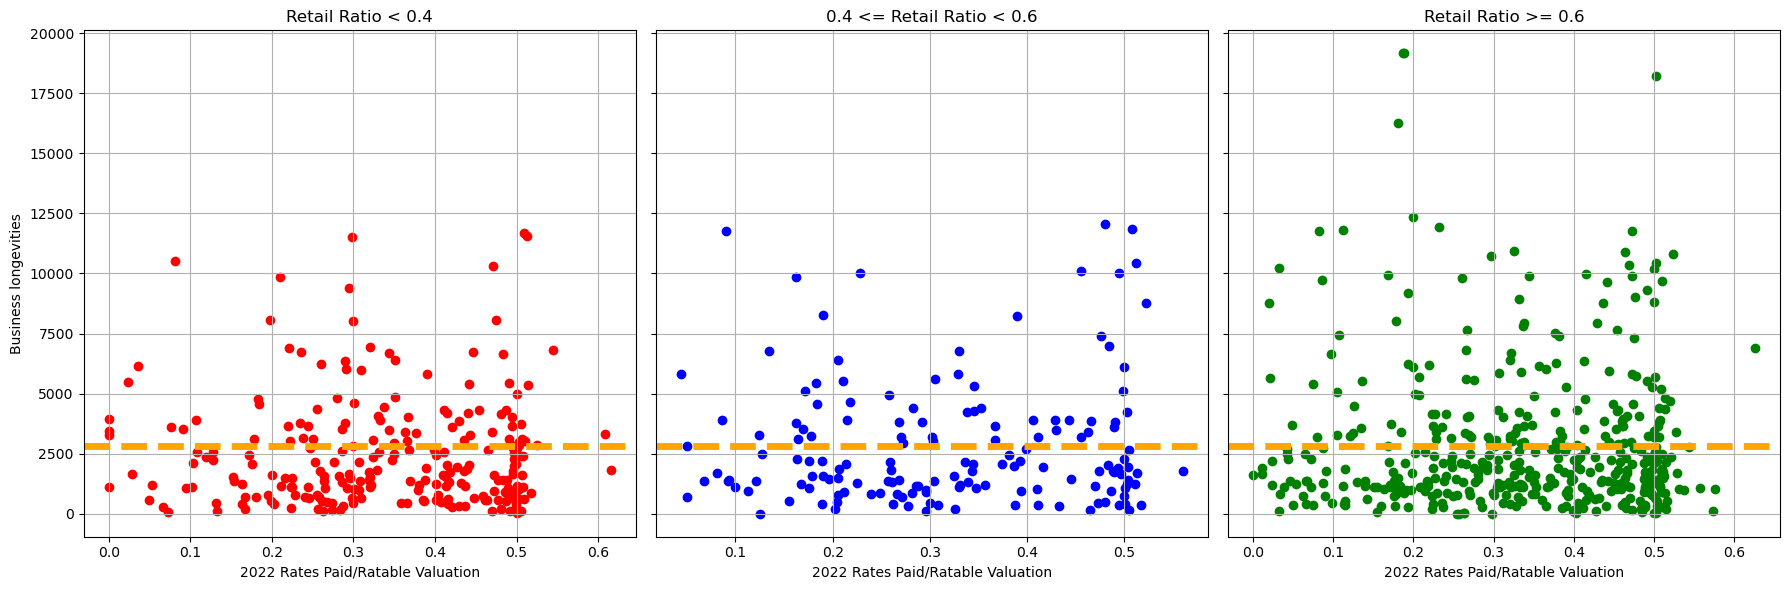

In [74]:
adv_rate_relief2022 = adv_rate_relief[['2022', 'df4_retail_ratio', 'df4_cluster']]
longevities2022 = pd.merge(adv_rate_relief2022, longevity_by_cluster2022, on='df4_cluster', how='inner')

print(longevities2022)

longevities2022['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in longevities2022['df4_retail_ratio']]

average_days_difference2022 = longevities2022['days_difference'].mean()
print (average_days_difference2022)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

red_points = longevities2022[longevities2022['color'] == 'red']
axes[0].scatter(red_points['2022'], red_points['days_difference'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2022 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('Business longevities')
axes[0].grid(True)
axes[0].axhline(average_days_difference2022, color='orange', linestyle='--', linewidth=5, label='Average longevity')

blue_points = longevities2022[longevities2022['color'] == 'blue']
axes[1].scatter(blue_points['2022'], blue_points['days_difference'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2022 Rates Paid/Ratable Valuation')
axes[1].grid(True)
axes[1].axhline(average_days_difference2022, color='orange', linestyle='--', linewidth=5, label='Average longevity')

yellow_points = longevities2022[longevities2022['color'] == 'green']
axes[2].scatter(yellow_points['2022'], yellow_points['days_difference'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2022 Rates Paid/Ratable Valuation')
axes[2].grid(True)
axes[2].axhline(average_days_difference2022, color='orange', linestyle='--', linewidth=5, label='Average longevity')

# Adjust layout and show plot
plt.tight_layout()
plt.show()

         2023  df5_retail_ratio  df5_cluster  days_difference
0    0.504483          0.826015          3.0      4475.000000
1    0.444220          0.099872         20.0      5632.000000
2    0.135410          0.490917         70.0      2663.362069
3    0.462649          0.982031         99.0      1207.000000
4    0.465325          0.806119        129.0      3264.000000
..        ...               ...          ...              ...
732  0.526066          0.200806       4366.0      3990.450000
733  0.528024          0.504393       4371.0      3231.142857
734  0.487448          0.410345       4388.0      3721.111111
735  0.094123          1.000000       4393.0       548.000000
736  0.512008          0.268261       4406.0      3829.230769

[737 rows x 4 columns]
2507.3640170591434


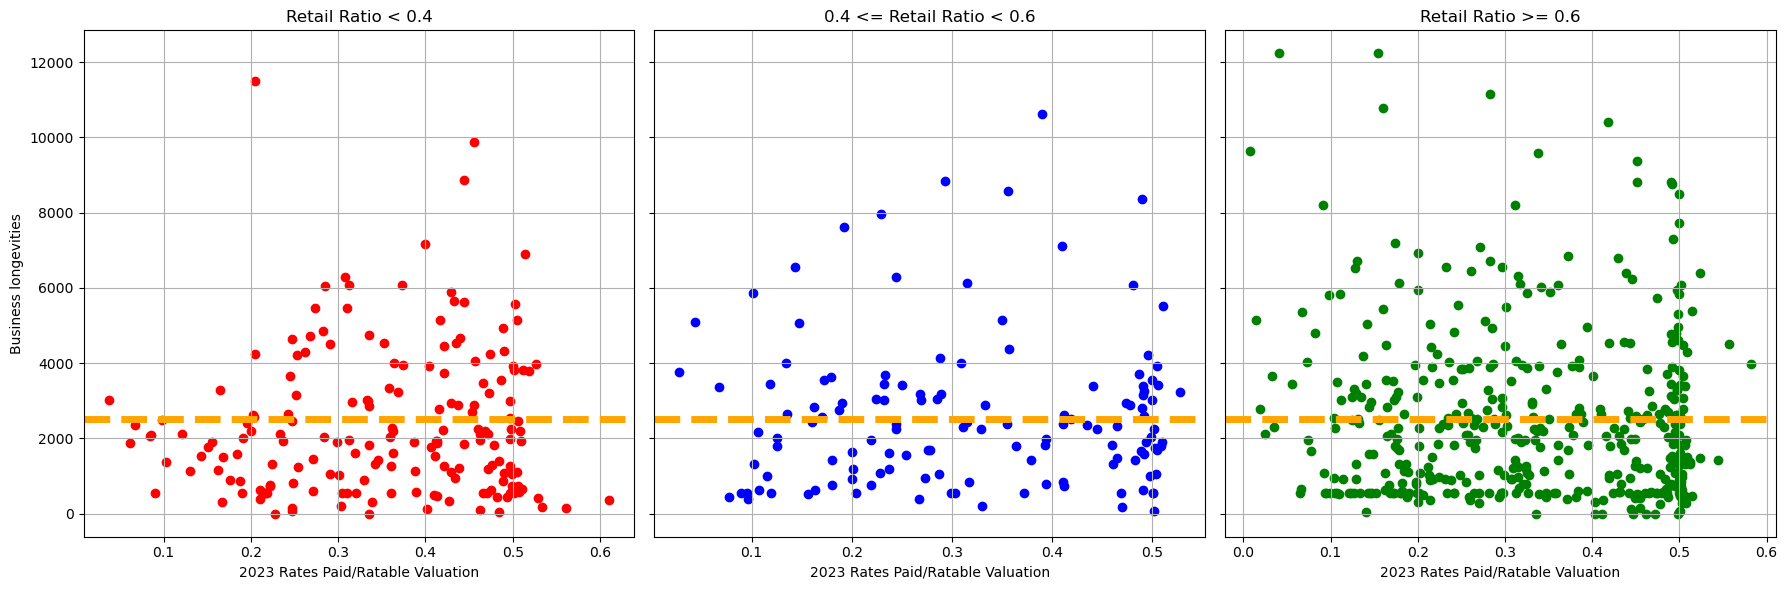

In [75]:
adv_rate_relief2023 = adv_rate_relief[['2023', 'df5_retail_ratio', 'df5_cluster']]
longevities2023 = pd.merge(adv_rate_relief2023, longevity_by_cluster2023, on='df5_cluster', how='inner')

print(longevities2023)

longevities2023['color'] = ['red' if x < 0.4 else 'blue' if x < 0.6 else 'green' for x in longevities2023['df5_retail_ratio']]

average_days_difference2023 = longevities2023['days_difference'].mean()
print (average_days_difference2023)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

red_points = longevities2023[longevities2023['color'] == 'red']
axes[0].scatter(red_points['2023'], red_points['days_difference'], color='red')
axes[0].set_title('Retail Ratio < 0.4')
axes[0].set_xlabel('2023 Rates Paid/Ratable Valuation')
axes[0].set_ylabel('Business longevities')
axes[0].grid(True)
axes[0].axhline(average_days_difference2023, color='orange', linestyle='--', linewidth=5, label='Average longevity')

blue_points = longevities2023[longevities2023['color'] == 'blue']
axes[1].scatter(blue_points['2023'], blue_points['days_difference'], color='blue')
axes[1].set_title('0.4 <= Retail Ratio < 0.6')
axes[1].set_xlabel('2023 Rates Paid/Ratable Valuation')
axes[1].grid(True)
axes[1].axhline(average_days_difference2023, color='orange', linestyle='--', linewidth=5, label='Average longevity')

yellow_points = longevities2023[longevities2023['color'] == 'green']
axes[2].scatter(yellow_points['2023'], yellow_points['days_difference'], color='green')
axes[2].set_title('Retail Ratio >= 0.6')
axes[2].set_xlabel('2023 Rates Paid/Ratable Valuation')
axes[2].grid(True)
axes[2].axhline(average_days_difference2023, color='orange', linestyle='--', linewidth=5, label='Average longevity')

# Adjust layout and show plot
plt.tight_layout()
plt.show()